In [9]:
# Function Definitions
import re
import os
import gc
import glob
import h5py
import shutil
import fnmatch
import itertools
import subprocess
import numpy as np
import hyperspy.api as hs
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy.spatial import KDTree
from scipy.interpolate import interp1d
from scipy.stats import linregress

from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

from diffractem.peakfinder8_extension import peakfinder_8


def findpeaks(h5_path, x0, y0, threshold, min_snr, min_pix_count, max_pix_count, local_bg_radius, min_res, max_res):
    all_results = []
    
    with h5py.File(h5_path, 'r+') as workingfile:  # Open the file in read/write mode
        print(f"started processing {os.path.basename(h5_path)}")
        stack_shape = workingfile['entry/data/images'].shape

        # Delete datasets if they already exist
        for dataset_name in ['nPeaks', 'peakTotalIntensity', 'peakXPosRaw', 'peakYPosRaw', 'index']:
            full_name = f'entry/data/{dataset_name}'
            if full_name in workingfile:
                del workingfile[full_name]
                print('peak datasets already exist - deleting old data')

        # Create new datasets
        for dataset_name in ['nPeaks', 'index']:
            full_name = f'entry/data/{dataset_name}'
            if full_name not in workingfile:
                workingfile.create_dataset(full_name, shape=(stack_shape[0],), dtype=int)

        for dataset_name in ['peakTotalIntensity', 'peakXPosRaw', 'peakYPosRaw']:
            full_name = f'entry/data/{dataset_name}'
            if full_name not in workingfile:
                workingfile.create_dataset(full_name, shape=(stack_shape[0], 500), dtype=float)  # 2D shape
        
        print('new datasets created')

        
        for i in range(stack_shape[0]):
                image_data = workingfile['entry/data/images'][i]
                result = findpeaks_single_frame(i, image_data, x0, y0, threshold, min_snr, min_pix_count, max_pix_count, local_bg_radius, min_res, max_res)
                all_results.append(result)

        # Populate the data after sorting the results
        all_results = sorted(all_results, key=lambda x: x['index'])
        print(workingfile['entry/data/peakTotalIntensity'].shape)     
         
        for res in all_results:
            idx = res['index']
            workingfile['entry/data/nPeaks'][idx] = res['nPeaks']
            truncated_peak_intensity = res['peakTotalIntensity'][:500]
            workingfile['entry/data/peakTotalIntensity'][idx] = truncated_peak_intensity
            truncated_peakXPosRaw = res['peakXPosRaw'][:500]
            workingfile['entry/data/peakXPosRaw'][idx] = truncated_peakXPosRaw
            truncated_peakYPosRaw = res['peakYPosRaw'][:500]
            workingfile['entry/data/peakYPosRaw'][idx] = truncated_peakYPosRaw
            workingfile['entry/data/index'][idx] = idx

    print(f"finished processing {os.path.basename(h5_path)}")

def findpeaks_single_frame(i, image_data, x0, y0, threshold, min_snr, min_pix_count, max_pix_count, local_bg_radius, min_res, max_res):
    if i % 1000 == 0:
       print(str(i) + ' frames processed') 

    nPeaks = 0
    X, Y = np.meshgrid(range(image_data.shape[1]), range(image_data.shape[0]))
    R = np.sqrt((X-x0)**2 + (Y-y0)**2).astype(np.float32)
    
    mask = np.ones_like(image_data, dtype=np.int8)
    mask[R > max_res] = 0
    mask[R < min_res] = 0

    pks = peakfinder_8(500, image_data.astype(np.float32), mask, R, image_data.shape[1], image_data.shape[0], 1, 1, threshold, min_snr, min_pix_count, max_pix_count, local_bg_radius)
    nPeaks = len(pks[0])   

    if pks is None or len(pks[0]) == 0:
        fill = [0] * (500)
        return {
            
            'index': i,
            'nPeaks': 0,
            'peakTotalIntensity': np.array(fill),
            'peakXPosRaw': np.array(fill),
            'peakYPosRaw': np.array(fill),
        }
    fill = [0] * (500 - nPeaks)

    return {
        'index': i,
        'nPeaks': nPeaks,
        'peakTotalIntensity': np.array(pks[2] + fill),
        'peakXPosRaw': np.array(pks[0] + fill),
        'peakYPosRaw': np.array(pks[1] + fill),
    }

# Now only h5 files in given folder
def find_files_and_run_peakfinding(folder_path, x0, y0, threshold, min_snr, min_pix_count, max_pix_count, local_bg_radius, min_res, max_res):
    # Only list files in the given folder, no subdirectories
    for filename in fnmatch.filter(os.listdir(folder_path), '*.h5'):
        filepath = os.path.join(folder_path, filename)
        # Call your processing function
        findpeaks(filepath, x0, y0, threshold, min_snr, min_pix_count, max_pix_count, local_bg_radius, min_res, max_res)

def divide_into_quarters(total_indices):
    # Calculate the frame range for each quarter center
    quarter_size = len(total_indices) // 4
    remaining = len(total_indices) % 4
    
    quarters = []
    start = 0
    for i in range(4):
        end = start + quarter_size + (1 if i < remaining else 0)
        quarters.append(total_indices[start:end])
        start = end

    return quarters

def find_friedel_pairs(peak_positions, current_center, tolerance):
    deviations = []
    for peak1 in peak_positions:
        for peak2 in peak_positions:
            deviation = peak1 + peak2 - 2 * np.array(current_center)
            if np.linalg.norm(deviation) < tolerance:
                deviations.append(deviation)
    return deviations

def find_center_with_friedel(h5file_path, min_peaks, tolerance, resolution_limit, subset_indices, current_center):
    all_deviations = []
    all_indices = []

    with h5py.File(h5file_path, 'r') as workingfile:
        indices_to_process = subset_indices if subset_indices is not None else range(len(workingfile['entry/data/nPeaks']))
        for i in indices_to_process:
            num_peaks = int(workingfile['entry/data/nPeaks'][i])

            if num_peaks < min_peaks:
                continue
                
            peak_xpos_raw = workingfile['entry/data/peakXPosRaw'][i][:num_peaks]
            peak_ypos_raw = workingfile['entry/data/peakYPosRaw'][i][:num_peaks]
            peak_positions = np.column_stack((peak_xpos_raw, peak_ypos_raw))
            
            # Filter out peaks based on resolution_limit
            distances = np.linalg.norm(peak_positions - current_center, axis=1)
            peak_positions = peak_positions[distances < resolution_limit]
            
            index = workingfile['entry/data/index'][i]
            
            deviations = find_friedel_pairs(peak_positions, current_center, tolerance)
            if deviations:
                all_deviations.extend(deviations)
                all_indices.extend([index]*len(deviations))
            
    return np.array(all_indices), np.array(all_deviations)

def fit_gaussian_to_largest_cluster(deviations, min_samples_fraction):
    # Fit a Gaussian distribution to largest cluster of deviations

    # Use DBSCAN for clustering
    #clustering = DBSCAN(eps=0.1, min_samples=int(min_samples_fraction*len(deviations))).fit(deviations)
    clustering = DBSCAN(eps=0.1, min_samples=5).fit(deviations)
    cluster_labels = clustering.labels_

    # Find the cluster labels (ignoring -1, which are 'noise' points)
    unique_labels = set(cluster_labels)
    if -1 in unique_labels:
        unique_labels.remove(-1)

    # Find the largest cluster
    cluster_sizes = [np.sum(cluster_labels == i) for i in unique_labels]
    if len(cluster_sizes) == 0:
        return None, None  # Handle the case where no cluster is found
    
    largest_cluster_index = list(unique_labels)[np.argmax(cluster_sizes)]

    # Filter deviations belonging to the largest cluster
    largest_cluster_deviations = deviations[cluster_labels == largest_cluster_index]

    # Fit Gaussian to the largest cluster
    gmm = GaussianMixture(n_components=1).fit(largest_cluster_deviations)
    mean = gmm.means_[0]
    covariance = gmm.covariances_[0]

    return mean, covariance

def iterative_gaussian_fitting_on_subset(h5file_path, initial_center, subset_indices, tolerance, min_peaks, resolution_limit, quarter_index, min_samples_fraction):
    # Perform Gaussian fitting to each subset of data
    current_center = initial_center
    mean_x, mean_y = float('inf'), float('inf')
    itcount = 0
    breakcriterion = 20 # break the loop if a center wasn't found after 20 iterations

    while mean_x > 0.4 or mean_y > 0.4:
        indices, deviations = find_center_with_friedel(h5file_path, min_peaks, tolerance, resolution_limit, subset_indices, current_center)

        itcount = itcount + 1

        # Check if deviations are empty, and if so, break the loop
        if len(deviations) == 0:
            break
        
        if itcount == breakcriterion + 1:
            print(f'No valid center found in quarter {quarter_index} after {breakcriterion} iterations.')
            break

        plt.close()
    
        mean, _ = fit_gaussian_to_largest_cluster(deviations, min_samples_fraction)

        if mean is not None:
            # Update the current center
            current_center = [current_center[0] + mean[0] / 2, current_center[1] + mean[1] / 2]

            # Calculate new means
            mean_x, mean_y = abs(mean[0]), abs(mean[1])

            # Create a plot     
            plt.figure(figsize=(6, 6))
            plt.scatter(deviations[:, 0], deviations[:, 1], label="Deviation Cloud", marker='o', s=0.01)
            plt.scatter(mean_x, mean_y, color='red', label="Final Center (" + str(round(current_center[0],3)) + ", " + str(round(current_center[1],3)) + ")", marker='x')
            plt.xlabel("X-deviation")
            plt.ylabel("Y-deviation")
            plt.legend()
            plt.title("Deviation Cloud in X/Y Plane with Final Center (q" + str(quarter_index) + "/it" + str(itcount) + ")")
            plt.show()
            plt.close()
        else:
            print(f'No cluster in deviation cloud found ({quarter_index}/{itcount:0{3}d}).')

            # Create a plot     
            plt.figure(figsize=(6, 6))
            plt.scatter(deviations[:, 0], deviations[:, 1], label="Deviation Cloud", marker='o', s=0.01)
            plt.xlabel("X-deviation")
            plt.ylabel("Y-deviation")
            plt.legend()
            plt.title("Deviation Cloud in X/Y Plane with Final Center (q" + str(quarter_index) + "/it" + str(itcount) + "), no cluster found")
            plt.show()
            plt.close()
            break

    print(f'Quarter {quarter_index} processed in {itcount - 1} iterations, final center = [{round(current_center[0],3)}, {round(current_center[1],3)}], mean deviation = [{mean_x:.3e},{mean_y:.3e}]')    
      
    return current_center, mean_x, mean_y, itcount

def set_center_based_on_line_fit(h5file_path, quarter_centers, framesize, framepath, exclude=[]):
    print('Interpolating centers based on linear fit')

    with h5py.File(h5file_path, 'r') as workingfile:
        total_frames = workingfile[framepath].shape[0]
    
    # Calculate the frame range for each quarter center
    quarter_size = total_frames // 4
    quarter_positions = [(i + 0.5) * quarter_size for i in range(4)]
    
    # Exclude specified quarters
    quarter_centers = [c for i, c in enumerate(quarter_centers) if i not in exclude]
    quarter_positions = [p for i, p in enumerate(quarter_positions) if i not in exclude]
    
    # Fit a line through the remaining quarter centers
    x = np.array(quarter_positions)
    y_x = np.array([c[0] for c in quarter_centers])
    y_y = np.array([c[1] for c in quarter_centers])
    
    slope_x, intercept_x, rvalue_x, _, _ = linregress(x, y_x)
    slope_y, intercept_y, rvalue_y, _, _ = linregress(x, y_y)

    # Warn if R^2 is bad
    if rvalue_x ** 2 <= 0.25:
        print(f'Warning: poor quality of x-fit (R^2 = {rvalue_x ** 2}), review your dataset or consider excluding data')
        
    if rvalue_y ** 2 <= 0.25:
        print(f'Warning: poor quality of y-fit (R^2 = {rvalue_y ** 2}), review your dataset or consider excluding data')
        
    # Generate new centers for each frame based on the line fit
    frame_positions = np.linspace(0, total_frames, total_frames)
    updated_x = slope_x * frame_positions + intercept_x
    updated_y = slope_y * frame_positions + intercept_y

    print(f'Scope of drift: {round((max(updated_x)-min(updated_x)),3)} px in x, {round((max(updated_y)-min(updated_y)),3)} px in y')
    
    # Plot the fit
    plt.figure()
    plt.scatter(quarter_positions, [c[0] for c in quarter_centers], label='Quarter Centers X', color='red')
    plt.scatter(quarter_positions, [c[1] for c in quarter_centers], label='Quarter Centers Y', color='blue')
    plt.plot(frame_positions, updated_x, label='Fitted Line X', color='orange')
    plt.plot(frame_positions, updated_y, label='Fitted Line Y', color='green')
    plt.xlabel('Frame Position')
    plt.ylabel('Center Value')
    plt.legend()
    
    # Calculate detector shifts in mm
    pixels_per_meter = 17857.14285714286  # Given constant
    presumed_center = framesize / 2  # Given constant
    det_shift_x_mm = -((updated_x - presumed_center) / pixels_per_meter) * 1000
    det_shift_y_mm = -((updated_y - presumed_center) / pixels_per_meter) * 1000
     
    # Write the updated centers to the HDF5 file
    with h5py.File(h5file_path, 'a') as workingfile:
        for ds_name in ['entry/data/center_x', 'entry/data/center_y', 'entry/data/det_shift_x_mm', 'entry/data/det_shift_y_mm']:
            if ds_name in workingfile:
                del workingfile[ds_name]
        
        workingfile.create_dataset('entry/data/center_x', data=updated_x, maxshape=(None,), dtype='float64')
        workingfile.create_dataset('entry/data/center_y', data=updated_y, maxshape=(None,), dtype='float64')
        workingfile.create_dataset('entry/data/det_shift_x_mm', data=det_shift_x_mm, maxshape=(None,), dtype='float64')
        workingfile.create_dataset('entry/data/det_shift_y_mm', data=det_shift_y_mm, maxshape=(None,), dtype='float64')
    
    print('Interpolated detector shifts written to HDF5 file')

    plt.show()

def find_centers(h5file_path, x0, y0, tolerance, min_peaks, resolution_limit, min_samples_fraction):
    framepath = 'entry/data/images'
    # Open HDF5 file to get total number of indices
    with h5py.File(h5file_path, 'r') as workingfile:
        total_indices = np.arange(len(workingfile['entry/data/index']))
        _,framesize_x,framesize_y = workingfile[framepath].shape

    # Define parameters dependent on frame dimesions
    framesize = framesize_x
    initial_center = [x0, y0]

    # Divide total_indices into quarters
    quarters = divide_into_quarters(total_indices)

    # Process each quarter
    quarter_centers = []

    for i, subset_indices in enumerate(quarters):
        quarter_index = i+1
        final_center, mean_x, mean_y, itcount = iterative_gaussian_fitting_on_subset(h5file_path, initial_center, subset_indices, tolerance, min_peaks, resolution_limit, quarter_index, min_samples_fraction)
        quarter_centers.append(final_center)

    set_center_based_on_line_fit(h5file_path, quarter_centers, framesize, framepath, exclude=[])

def refine_center_with_friedel(min_peaks, tolerance, resolution_limit, workingfile):
    all_deviations = []
    all_indices = []
    
    #with h5py.File(h5file_path, 'r') as workingfile:
    center_x = workingfile['entry/data/center_x'][:]
    center_y = workingfile['entry/data/center_y'][:]
        
    for i in range(len(workingfile['entry/data/index'])):
        num_peaks = workingfile['entry/data/nPeaks'][i]
            
        if num_peaks < min_peaks:
            continue
                
        peak_xpos_raw = workingfile['entry/data/peakXPosRaw'][i][:num_peaks]
        peak_ypos_raw = workingfile['entry/data/peakYPosRaw'][i][:num_peaks]
        peak_positions = np.column_stack((peak_xpos_raw, peak_ypos_raw))
            
        current_center = [center_x[i], center_y[i]]
            
       # Filter out peaks based on resolution_limit
        distances = np.linalg.norm(peak_positions - current_center, axis=1)
        peak_positions = peak_positions[distances < resolution_limit]
            
        index = workingfile['entry/data/index'][i]
            
        deviations = find_friedel_pairs(peak_positions, current_center, tolerance)
        if deviations:
            all_deviations.extend(deviations)
            all_indices.extend([index]*len(deviations))
            
    return np.array(all_indices), np.array(all_deviations)

def perform_lowess(indices, deviations, frac=0.1):
    if deviations.ndim != 2 or deviations.shape[1] != 2:
        raise ValueError
    
    lowess = sm.nonparametric.lowess
    z_x = lowess(deviations[:, 0], indices, frac=frac)
    z_y = lowess(deviations[:, 1], indices, frac=frac)
    return z_x, z_y

def plot_lowess_and_centers(lowess_fit_x, lowess_fit_y, original_center_x, original_center_y, existing_indices, itcount):
    print('plotting LOWESS fit')
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    fig.suptitle("Center coordinates (it" + str(itcount) + ")")

    # Plot for X-coordinate
    ax1 = axes[0]
    ax1.plot(existing_indices, original_center_x, label="Previous Center X", marker='o')
    ax1.set_xlabel("Index")
    ax1.set_ylabel("X-coordinate")
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.scatter(lowess_fit_x[:, 0], lowess_fit_x[:, 1], label="LOWESS fit for X-deviation", color='r', s=0.5)
    ax2.set_ylabel("LOWESS X-deviation")
    ax2.legend(loc='upper right')

    # Plot for Y-coordinate
    ax1 = axes[1]
    ax1.plot(existing_indices, original_center_y, label="Previous Center Y", marker='o')
    ax1.set_xlabel("Index")
    ax1.set_ylabel("Y-coordinate")
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.scatter(lowess_fit_y[:, 0], lowess_fit_y[:, 1], label="LOWESS fit for Y-deviation", color='g', s=0.5)
    ax2.set_ylabel("LOWESS Y-deviation")
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()
    plt.close()

def plot_deviations(indices, deviations):
    # Perform LOWESS fit
    z_x, z_y = perform_lowess(indices, deviations)

    plt.figure(figsize=(16, 6))
    plt.scatter(indices, deviations[:, 0], label="X-deviation", marker='o', s=0.3)
    plt.scatter(indices, deviations[:, 1], label="Y-deviation", marker='x', s=0.3)
    
    # Plot LOWESS fits
    plt.plot(z_x[:, 0], z_x[:, 1], label="LOWESS fit for X-deviation", color='r')
    plt.plot(z_y[:, 0], z_y[:, 1], label="LOWESS fit for Y-deviation", color='g')

    plt.xlabel("Frame")
    plt.ylabel("Deviation")
    plt.legend()
    plt.show()
    plt.close()

def refine(h5file_path, min_peaks, tolerance, resolution_limit, itcount, convergence_threshold, converged):
    # Open the HDF5 file to update the center_x and center_y datasets
    with h5py.File(h5file_path, 'r+') as workingfile:
        # Read existing center_x, center_y, and index
        existing_center_x = workingfile['entry/data/center_x'][:]
        existing_center_y = workingfile['entry/data/center_y'][:]
        existing_indices = workingfile['entry/data/index'][:]

        indices, deviations = refine_center_with_friedel(min_peaks, tolerance, resolution_limit, workingfile)
    
        # Perform LOWESS fit
        lowess_x, lowess_y = perform_lowess(indices, deviations)

        # Create interpolation functions for the LOWESS fit
        interp_lowess_x = interp1d(lowess_x[:, 0], lowess_x[:, 1], bounds_error=False, fill_value="extrapolate")
        interp_lowess_y = interp1d(lowess_y[:, 0], lowess_y[:, 1], bounds_error=False, fill_value="extrapolate")

        # Update centers based on LOWESS-smoothed deviations
        updated_center_x = existing_center_x + 0.5 * interp_lowess_x(existing_indices)
        updated_center_y = existing_center_y + 0.5 * interp_lowess_y(existing_indices)
        updated_center_x[0] = updated_center_x[1]
        updated_center_y[0] = updated_center_y[1]  

        plot_lowess_and_centers(lowess_x, lowess_y, existing_center_x, existing_center_y, existing_indices, itcount)

        # Update the HDF5 datasets
        workingfile['entry/data/center_x'][:] = updated_center_x
        workingfile['entry/data/center_y'][:] = updated_center_y

    # Check for convergence for each point
    convergence_x = all(np.abs(lowess_x[:, 1]) < convergence_threshold)
    convergence_y = all(np.abs(lowess_y[:, 1]) < convergence_threshold)
    
    plot_deviations(indices, deviations)

    if convergence_x and convergence_y:
        converged = True
        
    return indices, deviations, converged, itcount, updated_center_x, updated_center_y

def update_detector_shifts(h5file_path, updated_center_x, updated_center_y, framesize):
    pixels_per_meter = 17857.14285714286
    presumed_center = framesize / 2  # Half of the framesize
    det_shift_x_mm = -((updated_center_x - presumed_center) / pixels_per_meter) * 1000
    det_shift_y_mm = -((updated_center_y- presumed_center) / pixels_per_meter) * 1000
     
    # Write the updated centers to the HDF5 file
    with h5py.File(h5file_path, 'r+') as workingfile:
        for ds_name in ['entry/data/det_shift_x_mm', 'entry/data/det_shift_y_mm']:
            if ds_name in workingfile:
                del workingfile[ds_name]
        
        workingfile.create_dataset('entry/data/det_shift_x_mm', data=det_shift_x_mm, maxshape=(None,), dtype='float64')
        workingfile.create_dataset('entry/data/det_shift_y_mm', data=det_shift_y_mm, maxshape=(None,), dtype='float64')

    print('Updated detector shifts written to HDF5 file')

def refine_center_and_update(h5file_path, tolerance, min_peaks, resolution_limit, max_iterations, convergence_threshold):
    framepath = 'entry/data/images'
        # Open HDF5 file to get total number of indices
    with h5py.File(h5file_path, 'r') as workingfile:
        _,framesize_x,framesize_y = workingfile[framepath].shape

    framesize = framesize_x

    print(f"Working with {os.path.basename(h5file_path)}")

    itcount = 0
    converged = False

    while itcount < max_iterations and not converged:
        itcount += 1
        indices, deviations, converged, itcount, updated_center_x, updated_center_y = refine(h5file_path, min_peaks, tolerance, resolution_limit, itcount, convergence_threshold, converged)
    
    if converged:
        print(f'Convergence criterion (deviation from LOWESS < {convergence_threshold}) met after {itcount} iteration(s)')
    else:
        print(f'Could not meet convergenc criterion ({convergence_threshold}) after {itcount} iterations, refinement terminated')
        
    update_detector_shifts(h5file_path, updated_center_x, updated_center_y, framesize)

def find_files_and_run_centerfinding(folder_path, x0, y0, tolerance, min_peaks, resolution_limit, min_samples_fraction):
    # Only list files in the given folder, no subdirectories
    for filename in fnmatch.filter(os.listdir(folder_path), '*.h5'):
        filepath = os.path.join(folder_path, filename)
        # Call your centerfinding function
        find_centers(filepath, x0, y0, tolerance, min_peaks, resolution_limit, min_samples_fraction)

def find_files_and_run_centerrefinement(folder_path, tolerance, min_peaks, resolution_limit, max_iterations, convergence_threshold):
    # Only list files in the given folder, no subdirectories
    for filename in fnmatch.filter(os.listdir(folder_path), '*.h5'):
        filepath = os.path.join(folder_path, filename)
        # Call your center refinement function
        refine_center_and_update(filepath, tolerance, min_peaks, resolution_limit, max_iterations, convergence_threshold)


def list_h5_files(input_path):
    # Function to prepare list file
    listfile_path = os.path.join(input_path, 'list.lst')
    
    with open(listfile_path, 'w') as list_file:
        for root, dirs, files in os.walk(input_path):
            for file in files:
                if file.endswith('.h5'):
                    list_file.write(os.path.join(root, file) + '\n')

def generate_xy_pairs(x, y, step=0.01, layers=1): #1 layer means 2 layers i.e 5x5 pixels
    """Generate (x, y) pairs in a square pattern around a center."""
    center = (x,y)
    for layer in range(1, layers + 1):
        for dx, dy in itertools.product(range(-layer, layer + 1), repeat=2):
            if abs(dx) == layer or abs(dy) == layer:
                yield (center[0] + dx * step, center[1] + dy * step)

def modify_geometry_file(template_file_path, modified_file_path, x, y):
    """Modify the geometry file with new x, y values."""
    with open(template_file_path, 'r') as file:
        lines = file.readlines()
    
    with open(modified_file_path, 'w') as file:
        for line in lines:
            if line.startswith("p0/corner_x"):
                file.write(f"p0/corner_x = {x}\n")
            elif line.startswith("p0/corner_y"):
                file.write(f"p0/corner_y = {y}\n")
            else:
                file.write(line)

def run_indexamajig(x, y, geomfile_path, cellfile_path, input_path, output_file_base, num_threads, indexing_method, resolution_push, integration_method, int_radius, min_peaks, xgandalf_tolerance, xgandalf_sampling_pitch, xgandalf_min_vector_length, xgandalf_max_vector_length, xgandalf_iterations, tolerance):

    output_file = f"{output_file_base}_{x}_{y}.stream"
    output_path = os.path.join(input_path, output_file)
    listfile_path = os.path.join(input_path, 'list.lst')

    base_command = (
        f"indexamajig -g {geomfile_path} -i {listfile_path} -o {output_path} "
        f"-j {num_threads} -p {cellfile_path} --indexing={indexing_method} "
        f"--push-res={resolution_push} --no-retry --no-revalidate --multi "
        f"--integration={integration_method} --no-half-pixel-shift "
        f"--int-radius={int_radius} --no-refine --peaks=cxi "
        f"--max-indexer-threads=1 --min-peaks={min_peaks} "
        f"--xgandalf-tolerance={xgandalf_tolerance} "
        f"--xgandalf-sampling-pitch={xgandalf_sampling_pitch} "
        f"--xgandalf-min-lattice-vector-length={xgandalf_min_vector_length} "
        f"--xgandalf-max-lattice-vector-length={xgandalf_max_vector_length} "
        f"--xgandalf-grad-desc-iterations={xgandalf_iterations} "
        f"--tolerance={tolerance} --no-non-hits-in-stream --no-image-data"
    )

    subprocess.run(base_command, shell=True, check=True)

def gandalf_iterator(geomfile_path, cellfile_path, input_path, output_file_base, num_threads, indexing_method, resolution_push, integration_method, int_radius, min_peaks, xgandalf_tolerance, xgandalf_sampling_pitch, xgandalf_min_vector_length, xgandalf_max_vector_length, xgandalf_iterations, tolerance):
    list_h5_files(input_path)

    xdefault = -512
    ydefault = -512
    print(f"Running for initial x={str(xdefault)}, y={str(ydefault)}")
    
    # Start with the specified coordinates (-512, -512)
    try:
        
        
        #modify_geometry_file(-512, -512)
        modify_geometry_file(geomfile_path, geomfile_path, xdefault, ydefault)
        run_indexamajig(xdefault, ydefault, geomfile_path, cellfile_path, input_path, output_file_base, num_threads, indexing_method, resolution_push, integration_method, int_radius, min_peaks, xgandalf_tolerance, xgandalf_sampling_pitch, xgandalf_min_vector_length, xgandalf_max_vector_length, xgandalf_iterations, tolerance)
    except KeyboardInterrupt:
        print("Process interrupted by user.")
        exit()
    except subprocess.CalledProcessError as e:
        print(f"Error during initial indexamajig execution: {e}")
        exit()
    except Exception as e:
        print(f"Unexpected error during initial execution: {e}")
        exit()

    # Continue with the rest of the xy pairs
    xy_pairs = generate_xy_pairs(xdefault, ydefault, step=0.01, layers=2)  # Adjust the number of layers as needed

    for x, y in xy_pairs:
        print(f"Running for x={x}, y={y}")
        try:
            modify_geometry_file(geomfile_path, geomfile_path, x, y)
            run_indexamajig(x, y, geomfile_path, cellfile_path, input_path, output_file_base, num_threads, indexing_method, resolution_push, integration_method, int_radius, min_peaks, xgandalf_tolerance, xgandalf_sampling_pitch, xgandalf_min_vector_length, xgandalf_max_vector_length, xgandalf_iterations, tolerance)

        except KeyboardInterrupt:
            print("Process interrupted by user.")
            break
        except subprocess.CalledProcessError as e:
            print(f"Error during indexamajig execution: {e}")
        except Exception as e:
            print(f"Unexpected error: {e}")

def is_float(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

def parse_stream_file_v2(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    chunks = []
    current_chunk = {}
    chunk_text = []
    serial_number = None

    for line in lines:
        linestrip = line.strip()
        if linestrip == '----- Begin chunk -----':
            current_chunk = {'peaks': [], 'reflections': [], 'text': []}
            chunk_text = [line]
            serial_number = None
        elif linestrip == '----- End chunk -----':
            current_chunk['text'] = chunk_text + [line]
            chunks.append(current_chunk)
        else:
            chunk_text.append(line)
            if linestrip.startswith('Image serial number:'):
                serial_number = linestrip.split(':')[-1].strip()
                current_chunk['serial'] = serial_number
            elif linestrip.startswith('Event:'):
                current_event = int(re.search(r'\d+', linestrip).group())
                current_chunk['frame'] = current_event
            elif linestrip == 'Peaks from peak search':
                current_chunk['peaks_section'] = True
            elif linestrip == 'End of peak list':
                current_chunk['peaks_section'] = False
            elif linestrip == 'Reflections measured after indexing':
                current_chunk['reflections_section'] = True
            elif linestrip == 'End of reflections':
                current_chunk['reflections_section'] = False
            elif 'peaks_section' in current_chunk and current_chunk['peaks_section']:
                parts = linestrip.split()
                if len(parts) == 5 and all(is_float(part) for part in parts[:4]):
                    current_chunk['peaks'].append((float(parts[0]), float(parts[1]), float(parts[3])))
            elif 'reflections_section' in current_chunk and current_chunk['reflections_section']:
                parts = linestrip.split()
                if len(parts) == 10 and is_float(parts[-3]) and is_float(parts[-2]):
                    current_chunk['reflections'].append((float(parts[-3]), float(parts[-2])))

    return chunks

def find_nearest_neighbours(peaks, reflections, n=50):
    if not peaks or not reflections:
        return []
    if len(peaks) > n:
        peaks = sorted(peaks, key=lambda x: x[2], reverse=True)[:n]
    peak_coords = np.array([(peak[0], peak[1]) for peak in peaks])
    reflection_coords = np.array([(reflection[0], reflection[1]) for reflection in reflections])
    if peak_coords.size == 0 or reflection_coords.size == 0:
        return []
    tree = KDTree(reflection_coords)
    distances, _ = tree.query(peak_coords)
    rmsd = np.sqrt(np.mean(distances**2))
    return rmsd

def rmsd_analysis_v2(file_paths, n):
    best_results = {}
    stream_stats = {}

    for file_path in file_paths:
        chunks = parse_stream_file_v2(file_path)
        sum_rmsd = 0
        rmsd_count = 0
        indexed_patterns_count = 0  # Initialize counter for indexed patterns

        for chunk in chunks:
            rmsd = find_nearest_neighbours(chunk['peaks'], chunk['reflections'], n)
            if rmsd:  # Ensure there's a valid rmsd value
                sum_rmsd += rmsd
                rmsd_count += 1
                if chunk['serial'] not in best_results or best_results[chunk['serial']]['rmsd'] > rmsd:
                    best_results[chunk['serial']] = {'file_path': file_path, 'chunk': chunk, 'rmsd': rmsd}
            if chunk['reflections']:  # Check if the chunk has reflections, indicating indexing
                indexed_patterns_count += 1

        # Calculate and store statistics for this stream file
        if rmsd_count > 0:
            avg_rmsd = sum_rmsd / rmsd_count
        else:
            avg_rmsd = None
        stream_stats[file_path] = {
            'avg_rmsd': avg_rmsd,
            'chunk_count': len(chunks),
            'indexed_patterns_count': indexed_patterns_count  # Store the count of indexed patterns
        }

    # Print statistics for each stream file, including the number of indexed patterns
    for file_path, stats in stream_stats.items():
        print(f"File: {file_path}, Average RMSD: {stats['avg_rmsd']}, Chunk Count: {stats['chunk_count']}, Indexed Patterns: {stats['indexed_patterns_count']}")

    return best_results


def write_best_results_to_stream_v2(best_results, output_file_path):
    with open(output_file_path, 'w') as outfile:
        for serial, data in sorted(best_results.items(), key=lambda x: x[1]['rmsd']):
            chunk = data['chunk']
            for line in chunk['text']:
                outfile.write(line.rstrip('\r\n') + '\n')

def print_output_file_statistics(output_file_path, best_results):
    chunk_count = len(best_results)
    indexed_patterns_count = sum(1 for data in best_results.values() if data['chunk']['reflections'])  # Count chunks with reflections
    
    if chunk_count > 0:
        total_rmsd = sum(data['rmsd'] for data in best_results.values())
        average_rmsd = total_rmsd / chunk_count
    else:
        average_rmsd = "N/A"  # No chunks or RMSD data available
    
    # Adjusted print format for consistency
    print(f"File: {output_file_path}, Average RMSD: {average_rmsd:.3f}, Chunk Count: {chunk_count}, Indexed Patterns: {indexed_patterns_count}")

def find_stream_files(directory):
    # Check if the directory is a valid directory
    if not os.path.isdir(directory):
        raise ValueError("Provided path is not a valid directory")

    # List all files in the directory
    all_files = os.listdir(directory)

    # Filter files that end with 'stream'
    stream_files = fnmatch.filter(all_files, '*.stream')

    full_paths = [os.path.join(directory, file) for file in stream_files]

    return full_paths

def print_output_file_statistics(output_file_path, best_results):
    chunk_count = len(best_results)
    indexed_patterns_count = sum(1 for data in best_results.values() if data['chunk']['reflections'])  # Count chunks with reflections
    
    if chunk_count > 0:
        total_rmsd = sum(data['rmsd'] for data in best_results.values())
        average_rmsd = total_rmsd / chunk_count
    else:
        average_rmsd = "N/A"  # No chunks or RMSD data available
    
    # Adjusted print format for consistency
    print(f"File: {output_file_path}, Average RMSD: {average_rmsd:.3f}, Chunk Count: {chunk_count}, Indexed Patterns: {indexed_patterns_count}")

def find_and_copy_header(inputfolder_path, output_path):
    print(f"Adding header to {output_path}...")
    _, output_file = os.path.split(output_path)
    found_file_path = None

    for root, dirs, files in os.walk(inputfolder_path):
        for file in files:
            if file.endswith('.stream') and file != output_file:
                found_file_path = os.path.join(root, file)
                break
        if found_file_path:
            print(found_file_path)
            break

    with open(found_file_path, 'r', newline='') as source_file:
        lines = []
        for line in source_file:
            if "----- Begin chunk -----" in line:
                break
            lines.append(line)

    # Read existing best_results file
    with open(output_path, 'r', newline='') as target_file:
        existing_content = target_file.readlines()

    # Combine the new header with the existing content and write back
    combined_content = lines + existing_content


    with open(output_path, 'w', newline='') as target_file:
        target_file.writelines(combined_content)
    
    print(f"Header copied and added to {output_path}")

def find_best_results(folder_path, output_path):
    file_paths = find_stream_files(folder_path)

    print(file_paths)

    best_results = rmsd_analysis_v2(file_paths, n=10)

    write_best_results_to_stream_v2(best_results, output_path)

    print_output_file_statistics(output_path, best_results)

    find_and_copy_header(folder_path, output_path)

def read_stream_write_sol(stream_file_path, lattice):
    base,streamfile_name = os.path.split(stream_file_path)
    filename_without_extension, _ = os.path.splitext(streamfile_name)
    solfilename = filename_without_extension + '.sol'
    solfile_path = os.path.join(base,solfilename)

    with open(stream_file_path, 'r') as stream_file, open(solfile_path, 'w') as output_file:
        current_block = []
        for line in stream_file:
            line = line.strip()
            if line == '----- End chunk -----':  # End of a block
                if current_block:
                    # Process the current block before moving to the next one
                    process_block(current_block, output_file, lattice)
                current_block = []
            else:
                # Store each line in the current block
                current_block.append(line)

        # Process the last block
        if current_block:
            process_block(current_block, output_file)
            
######################
######################
# FAST INTEGRATION
######################
######################

import subprocess
import os

def run_script(bash_file_path):
    try:
        # Determine the directory of the bash script
        bash_dir = os.path.dirname(bash_file_path)

        # Start the script with the working directory set to the bash script's directory
        process = subprocess.Popen(['bash', bash_file_path], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, cwd=bash_dir)

        # Capture the output
        output, error = process.communicate()

        if process.returncode == 0:
            print("Script executed successfully")
            print("Output:", output)
        else:
            print("Script failed with return code", process.returncode)
            print("Error:", error)
    except Exception as e:
        print("An exception occurred:", e)

def update_bash_file(file_path, integration="rings", int_radius=(4,5,7)):
    if integration == "rings":
        inner, middle, outer = int_radius
        integrationext = f"{integration}_{inner}-{middle}-{outer}"
        int_radius_param = ",".join(map(str, int_radius))  # Convert tuple to comma-separated string
    else:
        integrationext = integration
    
    new_lines = []
    with open(file_path, 'r') as file:
        for line in file:
            if '-o' in line:  # This check is still valid since -o is a separate argument
                parts = line.split()
                # Update the output file name
                output_file_index = parts.index('-o') + 1
                output_file = parts[output_file_index]
                base_name, ext = output_file.split('.')
                new_output_file = f"{base_name}_{integrationext}.{ext}"
                parts[output_file_index] = new_output_file
                
                for i, part in enumerate(parts):
                    if '--integration' in part:
                        parts[i] = f'--integration={integration}'
                    elif '--int-radius' in part and integration == "rings":
                        parts[i] = f'--int-radius={int_radius_param}'
                line = ' '.join(parts)

            new_lines.append(line)

    with open(file_path, 'w') as file:
        file.writelines(new_lines)

def reset_bash_path(file_path, output_stream_format):
    new_lines = []
    with open(file_path, 'r') as file:
        for line in file:
            if '-o' in line:
                parts = line.split()
                parts[parts.index('-o') + 1] = output_stream_format
                new_lines.append(' '.join(parts) + '\n')
            else:
                new_lines.append(line)
    
    with open(file_path, 'w') as file:
        file.writelines(new_lines)

def generate_ring_sizes(min_val, max_val):
    ring_sizes = []
    for a in range(min_val, max_val + 1):
        for b in range(a + 1, a + 2):
            for c in range(b + 1, b + 2):
                ring_sizes.append((a, b, c))
    return ring_sizes    

def integration(bash_file_path, output_stream_format, integration="rings", ring_sizes = None):
    if integration == "rings":
        for int_radius in ring_sizes:
            reset_bash_path(bash_file_path, output_stream_format)
            update_bash_file(bash_file_path, integration, int_radius) 
            run_script(bash_file_path)
            reset_bash_path(bash_file_path, output_stream_format)
    else:
        reset_bash_path(bash_file_path, output_stream_format)
        update_bash_file(bash_file_path, integration)
        run_script(bash_file_path)
        reset_bash_path(bash_file_path, output_stream_format) 

######################
######################
######################
######################
######################

def process_block(block, output_file, lattice):
    try:
        image = ''
        event = ''
        det_shift_x = ''
        det_shift_y = ''
        astar_values = ''
        bstar_values = ''
        cstar_values = ''

        for line in block:
            if line.startswith('Image filename:'):
                image = line.split(':', 1)[1].strip()
            elif line.startswith('Event:'):
                event = line.split(':', 1)[1].strip()
            elif 'predict_refine/det_shift' in line:
                det_shifts = line.split()
                if len(det_shifts) >= 7:
                    det_shift_x = det_shifts[3]
                    det_shift_y = det_shifts[6]
            elif 'astar' in line:
                astar_values = ' '.join(line.split()[2:5])
                #print(astar_values)
            elif 'bstar' in line:
                bstar_values = ' '.join(line.split()[2:5])
                #print(bstar_values)
            elif 'cstar' in line:
                cstar_values = ' '.join(line.split()[2:5])
                #print(cstar_values)

        if image and event and astar_values and bstar_values and cstar_values and det_shift_x and det_shift_y:
            det_shifts = f"{det_shift_x} {det_shift_y}"
            output_line = f"{image} {event} {astar_values} {bstar_values} {cstar_values} {det_shifts} {lattice}\n"
            output_file.write(output_line)

    except Exception as e:
        print(f"Error processing block: {e}")

def run_indexamajig_with_frames(x, y, geomfile_path, cellfile_path, input_path, num_threads, indexing_method, resolution_push, integration_method, int_radius, min_peaks, xgandalf_tolerance, xgandalf_sampling_pitch, xgandalf_iterations, tolerance):
    modify_geometry_file(geomfile_path, geomfile_path, x, y)
    
    try:
        listfile_path = next((os.path.join(input_path, f) for f in os.listdir(input_path) if f.endswith('.lst')), None)
        solfile_path = next((os.path.join(input_path, f) for f in os.listdir(input_path) if f.endswith('.sol')), None)
        if not listfile_path or not solfile_path:
            raise FileNotFoundError("Required .list or .sol file not found.")
        
        _, output_file_base = os.path.split(input_path)
        output_file = f"{output_file_base}_{x}_{y}_pushres{resolution_push}_rings_{int_radius.replace(',', '-')}.stream"
        output_path = os.path.join(input_path, output_file)

        base_command = (
            f"indexamajig -g {geomfile_path} -i {listfile_path} -o {output_path} -j {num_threads} -p {cellfile_path} --indexing={indexing_method} --no-revalidate --no-check-peaks --no-retry --push-res={resolution_push} --integration={integration_method} --overpredict --no-refine --fromfile-input-file={solfile_path} --no-half-pixel-shift --int-radius={int_radius} --no-check-cell --peaks=cxi --max-indexer-threads=4 --min-peaks={min_peaks} --xgandalf-tolerance={xgandalf_tolerance} --xgandalf-sampling-pitch={xgandalf_sampling_pitch} --xgandalf-grad-desc-iterations={xgandalf_iterations} --tolerance={tolerance} --no-non-hits-in-stream"
        )

        print(base_command)

        subprocess.run(base_command, shell=True, check=True)
    except Exception as e:
        print(f"An error occurred: {e}")

def merge_and_write_mtz(stream_dir, cellfile_path, pointgroup):
    run = 1
    stream_files = glob.glob(f'{stream_dir}*.stream')  

    for stream_file in stream_files:
        ring_sizes_match = re.search(r'_rings_([0-9-]+)\.stream', stream_file)
        if not ring_sizes_match:
            continue

        ring_sizes = ring_sizes_match.group(1)
        output_dir_base = os.path.join(stream_dir, f'merge-{ring_sizes}-run')
        output_dir = f"{output_dir_base}{run}"

        while True:
            try:
                os.makedirs(output_dir)
                break  
            except FileExistsError:
                run += 1  
                output_dir = f"{output_dir_base}{run}"

        os.makedirs(os.path.join(output_dir, "pr-logs"), exist_ok=True)

        merging_cmd = [
            'partialator', 
            stream_file,
            '--model=offset',
            '-j', '23',
            '-o', os.path.join(output_dir, "crystfel.hkl"),
            '-y', pointgroup,
            '--polarisation=none',
            '--min-measurements=2',
            '--max-adu=inf',
            '--min-res=inf',
            '--push-res=inf',
            '--no-Bscale',
            # '--no-pr',
            '--no-logs',
            '--iterations=3',
            '--harvest-file=' + os.path.join(output_dir, "parameters.json"),
            '--log-folder=' + os.path.join(output_dir, "pr-logs")
        ]

        hkl2mtz_cmd = [
            'get_hkl',
            '-i', f'{output_dir}/crystfel.hkl',
            '-o', f'{output_dir}/output.mtz',
            '-p', f'{cellfile_path}',
            '--output-format=mtz'
        ]


        with open(os.path.join(output_dir, "stdout.log"), "w") as stdout, open(os.path.join(output_dir, "stderr.log"), "w") as stderr:
            print(f"Running merging for ring sizes: {ring_sizes}")
            subprocess.run(merging_cmd, stdout=stdout, stderr=stderr)
            subprocess.run(hkl2mtz_cmd, stdout=stdout, stderr=stderr)

Conversion from .emd to .h5 format.

In [ ]:
# Conversion Function Definitions


def find_path_in_h5(h5file):
    base_path = '/Data/Image/'
    if base_path in h5file:
        image_group = h5file[base_path]
        for subfolder in image_group:
            print(subfolder)
            data_path = f'{base_path}{subfolder}/Data'
            if data_path in h5file:
                print(data_path)
                return data_path

def velox_conversion(h5file_path):
    print('converting ' + str(h5file_path))
    backup_file_path = h5file_path + ".backup"
    base_name = os.path.splitext(h5file_path)[0]
    new_file_path = base_name + ".h5"
    
    with h5py.File(h5file_path, 'r+') as workingfile:
        framepath = find_path_in_h5(workingfile)

    print(f'original datset located in: {framepath}')
    new_framepath = 'entry/data/images'

    # Rename the original file
    shutil.move(h5file_path, backup_file_path)
    print("original file renamed to backup")

    # Create a new file with the original name
    with h5py.File(new_file_path, 'w') as new_file, h5py.File(backup_file_path, 'r') as backup_file:
        print("new file created with the original name")

        # Chunk and write the frames
        print(f"started copying image data")    
        dataset = backup_file[framepath]
        x_dim, y_dim, z_dim = dataset.shape
        chunk_size = (1000, y_dim, x_dim)
        new_dataset_name = new_framepath

        chunked_dataset = new_file.create_dataset(new_dataset_name, shape=(z_dim, y_dim, x_dim),dtype=dataset.dtype, chunks=chunk_size)
        for z in range(z_dim):
            chunked_dataset[z, :, :] = dataset[:, :, z]
            
        print("chunked dataset created and data copied")

    # Delete original file
    os.remove(backup_file_path)
    print("conversion successful, backup file deleted")

def find_and_process_velox_files(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for filename in fnmatch.filter(files, '*.emd'):
            filepath = os.path.join(root, filename)
            velox_conversion(filepath)

def ser_conversion(originalfile_path):
    print('converting ' + str(originalfile_path))
    emi_data = hs.load(originalfile_path, only_valid_data=True)
    n_frames, height, width = emi_data.data.shape

    chunk_size = (1000, height, width)

    base_name = os.path.splitext(originalfile_path)[0]
    output_h5_file = base_name + ".h5"

    # Backup and rename existing file
    if os.path.exists(output_h5_file):
        backup_file_path = output_h5_file + ".backup"
        shutil.move(output_h5_file, backup_file_path)

    # Create new HDF5 file for output
    with h5py.File(output_h5_file, 'w') as h5f:
        # Create dataset for storing frames
        new_framepath = 'entry/data/images'
        dset = h5f.create_dataset(new_framepath, shape=(n_frames, height, width), dtype=np.float32, chunks=chunk_size)

        print(f"started processing and chunking EMI data into {output_h5_file}")
        # Process and write the data in chunks
        for start in range(0, n_frames, chunk_size[0]):
            end = min(start + chunk_size[0], n_frames)
            # Load a chunk
            chunk_data = emi_data.data[start:end, :, :].astype(np.float32)
            # Write the chunk
            dset[start:end, :, :] = chunk_data
            del chunk_data
            gc.collect()

        print("SER file successfully converted and chunked into HDF5 format")

    # Cleanup
    del emi_data
    gc.collect()
    os.remove(originalfile_path)
    print("conversion successful, backup file deleted")

def find_and_process_ser_files(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for filename in fnmatch.filter(files, '*.ser'):
            filepath = os.path.join(root, filename)
            ser_conversion(filepath)


In [ ]:
# Convert to HDF5
inputfolder_path= r"/mnt/c/Users/bubl3932/Desktop/TEST"

find_and_process_velox_files(inputfolder_path)

Peakfinding using peakfinder8 from diffractem package. First open .h5 file in crystfel using .geom file that refers to correct mask file and find good peakfinding settings. Make sure there are enough friedel pairs for center beam finding and fitting. Don't put the mask in the same folder as the .h5 file since it is also .h5 format. If peakfinding has been run old data will be deleted. (About 2000 frames processed per minute depending on PF settings).

In [2]:
# Peak Finder Function Definitions

import os
import datetime
import configparser
import h5py
import dask.array as da 
from concurrent.futures import ProcessPoolExecutor, as_completed

def shoutout(configfile_path):
    print(f'working with {configfile_path}')

def log_start(logfile_path, message):
    print(message)
    with open(f'{logfile_path}', 'a') as file:
                    file.write(f'{datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]}; {message}\n')

def handle_input(input_path):
    configfiles = []
    new_input_path = input_path
    
    # Check if the input is already a list
    if isinstance(input_path, list):
        # Check if all files are in the same directory and are .ini files
        directory = None
        for path in input_path:
            if not os.path.isfile(path) or not path.endswith('.ini'):
                raise ValueError(f"Each item in the list must be a .ini file. Invalid path: {path}")

            current_directory, _ = os.path.split(path)
            if directory is None:
                directory = current_directory
            elif directory != current_directory:
                raise ValueError("All files in the list must be in the same directory.")

        configfiles = input_path
        new_input_path = directory
    elif os.path.isdir(input_path):
        # List all .ini files in the input folder
        configfiles = [os.path.join(input_path, file) for file in os.listdir(input_path) if file.endswith('.ini')]
    elif os.path.isfile(input_path) and input_path.endswith('.ini'):
        # If it's a single file, add it to the list
        configfiles = [input_path]
        new_input_path, _ = os.path.split(input_path)
    else:
        # Handle cases where the input is neither a folder, a valid file, nor a list
        raise ValueError("Input must be a folder, a .ini file, or a list of .ini files")

    return configfiles, new_input_path
      
def write_peakfindersettings(input_path, cutoff_low, cutoff, 
                             threshold, min_snr, 
                             min_pix_count, max_pix_count, 
                             local_bg_radius, min_res, max_res, 
                             num_threads, x0, y0):

    configfiles, input_path = handle_input(input_path)

    for configfile in configfiles:

        configfile_path = os.path.join(input_path,configfile)
        shoutout(configfile_path)

        # Update paths
        config = configparser.ConfigParser()
        config.read(configfile_path)

        outputfolder = config.get('Paths','outputfolder')
        logfile = config.get('Paths','logfile')
        path, _ = os.path.split(configfile_path)
        logfile_path = os.path.join(path,outputfolder,logfile)

        # Set parameters
        parameters_to_set = {
            'peakfinding_cutoff': cutoff,
            'peakfinding_cutoff_low': cutoff_low,
            'peakfinding_threshold': threshold,
            'peakfinding_min_snr': min_snr,
            'peakfinding_min_pix_count': min_pix_count,
            'peakfinding_max_pix_count': max_pix_count,
            'peakfinding_local_bg_radius': local_bg_radius,
            'peakfinding_min_res': min_res,
            'peakfinding_max_res': max_res,
            'peakfinding_x0': x0,
            'peakfinding_y0': y0,
            'peakfinding_num_threads': num_threads
        }

        for param, value in parameters_to_set.items():
            config.set('Parameters', param, str(value))

        # Write configfile and log
        with open(configfile_path, 'w') as configfile:
            config.write(configfile)
        
        log_start(logfile_path, f'peakfinder settings set, cutoff = {cutoff}, cutoff_low = {cutoff_low}, threshold = {threshold}, min_snr = {min_snr}, min_pix_count = {min_pix_count}, max_pix_count = {max_pix_count}, local_bg_radius = {local_bg_radius}, min_res = {min_res}, max_res = {max_res}, num_threads = {num_threads}')
        log_start(logfile_path, f'detector geometry set, x0 = {x0}, y0 = {y0}')
        
        # Parameter sensibility checks
        if max_pix_count <= 2 * min_pix_count:
            log_start(logfile_path, 'Warning: max_px_count is close or eaqual to min_px_count, attempting to find very specific peak sizes may lead to a small number of identified peaks.')

        if max_res <= 2 * min_res:
            log_start(logfile_path, 'Warning: max_res is close or eaqual to min_res, this might prevent peakfinder8 form identfying any peaks')

def parse_config(configfile):
    config = configparser.ConfigParser()
    config.read(configfile)

    # Required parameters
    outputfolder = config.get('Paths', 'outputfolder')
    originalfile = config.get('Paths', 'originalfile')
    logfile = config.get('Paths', 'logfile')
    path, _ = os.path.split(configfile)
    outputfolder_path = os.path.join(path, outputfolder)
    originalfile_path = os.path.join(path, originalfile)
    logfile_path = os.path.join(outputfolder_path, logfile)
    
    # Optional parameters
    framepath = config.get('Paths','framepath', fallback=None)
    h5file = config.get('Paths', 'h5file', fallback=None)
    h5file_path = os.path.join(outputfolder_path, h5file) if h5file else None

    return config, outputfolder, originalfile, logfile, path, outputfolder_path, originalfile_path, logfile_path, framepath, h5file, h5file_path

def process_image(i, image_data, x0, y0, cutoff, cutoff_low, threshold, min_snr, min_pix_count, max_pix_count, local_bg_radius, min_res, max_res):
    nPeaks = 0
    X, Y = np.meshgrid(range(image_data.shape[1]), range(image_data.shape[0]))
    R = np.sqrt((X-x0)**2 + (Y-y0)**2).astype(np.float32)
    
    mask = np.ones_like(image_data, dtype=np.int8)
    mask[R > max_res] = 0
    mask[R < min_res] = 0

    pks = peakfinder_8(500, image_data.astype(np.float32), mask, R, image_data.shape[1], image_data.shape[0], 1, 1, threshold, min_snr, min_pix_count, max_pix_count, local_bg_radius)
    nPeaks = len(pks[0])
    #print(nPeaks)
    if pks is None or len(pks[0]) == 0:
        fill = [0] * (500)
        return {
            'index': i,
            'nPeaks': 0,
            'peakTotalIntensity': np.array(fill),
            'peakXPosRaw': np.array(fill),
            'peakYPosRaw': np.array(fill),
        }

    fill = [0] * (500 - nPeaks)
    return {
        'index': i,
        'nPeaks': nPeaks,
        'peakTotalIntensity': np.array(pks[2] + fill),
        'peakXPosRaw': np.array(pks[0] + fill),
        'peakYPosRaw': np.array(pks[1] + fill),
    }

def process_batch(images_batch, x0, y0, cutoff, cutoff_low, num_threads, threshold, min_snr, min_pix_count, max_pix_count, local_bg_radius, min_res, max_res, logfile_path, h5file_path):
    #print(f"Starting processing of {len(images_batch)} images in batch.")
    batch_results = []
    with ProcessPoolExecutor(max_workers=num_threads) as executor:
        futures = []
        for i, image_data in enumerate(images_batch):
            future = executor.submit(process_image, i, image_data, x0, y0, cutoff, cutoff_low, threshold, min_snr, min_pix_count, max_pix_count, local_bg_radius, min_res, max_res)
            futures.append(future)

        for future in as_completed(futures):
            result = future.result()
            if result:
                batch_results.append(result)
    #print(f"Completed processing of {len(images_batch)} images in batch.")
    return batch_results

def process_file(h5file_path, x0, y0, cutoff, cutoff_low, num_threads, threshold, min_snr, min_pix_count, max_pix_count, local_bg_radius, min_res, max_res, logfile_path, batch_size):
    with h5py.File(h5file_path, 'r+') as f:
        log_start(logfile_path, f'start peak finding in {os.path.basename(h5file_path)}, cutoff = {cutoff}, cutoff_low = {cutoff_low}, threshold = {threshold}, min_snr = {min_snr}, min_pix_count = {min_pix_count}, max_pix_count = {max_pix_count}, local_bg_radius = {local_bg_radius}, min_res = {min_res}, max_res = {max_res}, num_threads = {num_threads}')
        
        total_process_start_time = datetime.datetime.now()
        
        dask_images = da.from_array(f['entry/data/images'], chunks=(batch_size, -1, -1))

        dataset_length = len(dask_images)

        num_batches = dask_images.shape[0] // batch_size
        if dask_images.shape[0] % batch_size != 0:
            num_batches += 1

        log_start(logfile_path, f'processing in {num_batches} batches of {batch_size} frames')

        # Delete datasets if they already exist
        for dataset_name in ['nPeaks', 'peakTotalIntensity', 'peakXPosRaw', 'peakYPosRaw', 'index']:
            full_name = f'entry/data/{dataset_name}'
            if full_name in f:
                del f[full_name]

        # Create or resize datasets
        for dataset_name in ['nPeaks', 'index']:
            full_name = f'entry/data/{dataset_name}'
            if full_name not in f:
                f.create_dataset(full_name, shape=(dask_images.shape[0],), dtype=int)

        for dataset_name in ['peakTotalIntensity', 'peakXPosRaw', 'peakYPosRaw']:
            full_name = f'entry/data/{dataset_name}'
            if full_name not in f:
                f.create_dataset(full_name, shape=(dask_images.shape[0], 500), dtype=float)  # 2D shape


        for batch_idx in range(num_batches):
            batch_start_time = datetime.datetime.now()

            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, dask_images.shape[0])
            #print(f"processing batch {batch_idx+1}/{num_batches}, images {start_idx} to {end_idx-1}")
            log_start(logfile_path,f'start processing batch {batch_idx+1}/{num_batches}, images {start_idx} to {end_idx-1}')

        
            # Use Dask's compute() method to load the batch into memory
            images_batch = dask_images[start_idx:end_idx].compute()

            # Process each batch
            batch_results = process_batch(images_batch, x0, y0, cutoff, cutoff_low, num_threads, threshold, min_snr, min_pix_count, max_pix_count, local_bg_radius, min_res, max_res, logfile_path, h5file_path)
            
            # Estimate the time of completion
            batch_end_time = datetime.datetime.now()  # Record end time of the current batch
            runtime = batch_end_time - total_process_start_time
            remaining_batches = num_batches - (batch_idx + 1)
            processed_frames = (batch_idx + 1) * batch_size
            remaining_frames = dataset_length - processed_frames
            estimated_remaining_time = runtime / processed_frames * remaining_frames
            
            etc = datetime.datetime.now() + estimated_remaining_time

            log_start(logfile_path,f'finished processing batch {batch_idx+1}/{num_batches}, images {start_idx} to {end_idx-1}')

            print(f'estimated time of completion: {etc}')

            # Write results back to file
            for result in batch_results:
                # Adjust index for batch offset
                idx = result['index'] + start_idx
                f['entry/data/nPeaks'][idx] = result['nPeaks']
                truncated_peak_intensity = result['peakTotalIntensity'][:500]
                f['entry/data/peakTotalIntensity'][idx] = truncated_peak_intensity
                truncated_peakXPosRaw = result['peakXPosRaw'][:500]
                f['entry/data/peakXPosRaw'][idx] = truncated_peakXPosRaw
                truncated_peakYPosRaw = result['peakYPosRaw'][:500]
                f['entry/data/peakYPosRaw'][idx] = truncated_peakYPosRaw
                f['entry/data/index'][idx] = idx

        log_start(logfile_path,f'processing of {os.path.basename(h5file_path)} complete')

def findpeaks8_batch(input_path, batch_size=5000):
    configfiles, input_path = handle_input(input_path)
    print(f'following .ini files were found and will be processed:')
    print(f'{configfiles}')
    counter = 1

    for configfile in configfiles:
        config, outputfolder, originalfile, logfile, path, outputfolder_path, originalfile_path, logfile_path, framepath, h5file, h5file_path = parse_config(configfile)
        
        #print(f"Working with {os.path.basename(configfile_path)}")

        # Check if necessary parameters are defined
        for param in ['peakfinding_cutoff','peakfinding_cutoff_low','peakfinding_threshold','peakfinding_min_snr','peakfinding_min_pix_count','peakfinding_max_pix_count','peakfinding_local_bg_radius','peakfinding_min_res','peakfinding_x0','peakfinding_y0','peakfinding_num_threads']:
            if not config.has_option('Parameters', param):
                with open(f'{logfile_path}', 'a') as file:
                    file.write(f'{datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]}; Error: {param.split("_", 1)[1]} not defined, peak finding interrupted\n')
                raise Exception(f'{param.split("_", 1)[1]} not defined')

        # Load parameters
        cutoff = float(config.get('Parameters', 'peakfinding_cutoff'))
        cutoff_low = float(config.get('Parameters', 'peakfinding_cutoff_low'))
        threshold = float(config.get('Parameters', 'peakfinding_threshold'))
        min_snr = float(config.get('Parameters', 'peakfinding_min_snr'))
        min_pix_count = float(config.get('Parameters', 'peakfinding_min_pix_count'))
        max_pix_count = float(config.get('Parameters', 'peakfinding_max_pix_count'))
        local_bg_radius = float(config.get('Parameters', 'peakfinding_local_bg_radius'))
        min_res = float(config.get('Parameters', 'peakfinding_min_res'))
        max_res = float(config.get('Parameters', 'peakfinding_max_res'))
        x0 = int(config.get('Parameters', 'peakfinding_x0'))
        y0 = int(config.get('Parameters', 'peakfinding_y0'))
        num_threads = int(config.get('Parameters', 'peakfinding_num_threads'))

        process_file(h5file_path, x0, y0, cutoff, cutoff_low, num_threads, threshold, min_snr, min_pix_count, max_pix_count, local_bg_radius, min_res, max_res, logfile_path, batch_size)
        if counter <= len(configfiles):
            print(f"proceeding to next task (file {counter+1}/{len(configfiles)})")
        print("")
        counter = counter + 1

    print(f"batch finished ({counter}/{len(configfiles)})")


In [3]:
# Peak Finder
input_path= r"/mnt/c/Users/bubl3932/Desktop/R2aOxC1"

# Peakfinder settings:
cutoff_low= 15 
cutoff = 25
threshold = 80
min_snr = 3
min_pix_count = 2
max_pix_count = 200
local_bg_radius = 9
min_res = 0
max_res = 1000
x0 = 512
y0 = 512  
num_threads = 23
##### Enter parameters above #####

write_peakfindersettings(input_path, cutoff_low, cutoff, 
                         threshold, min_snr, 
                         min_pix_count, max_pix_count, 
                         local_bg_radius, min_res, max_res, 
                         num_threads, x0, y0)

batch_size=4000

findpeaks8_batch(input_path,batch_size) 

following .ini files were found and will be processed:
[]
batch finished (1/0)


Find the center beam spot center on all frames using friedel pairs and  interpolation.

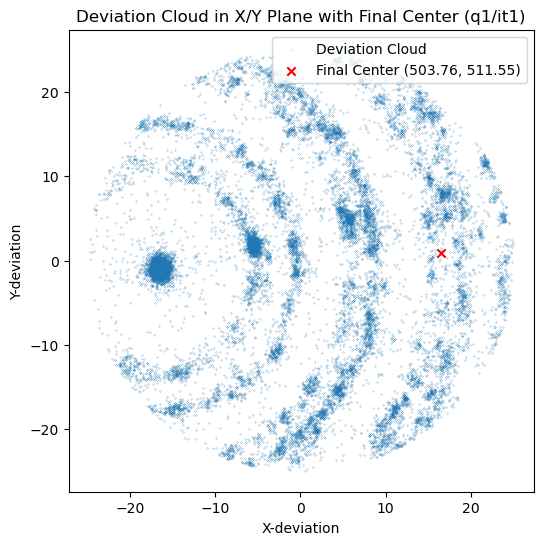

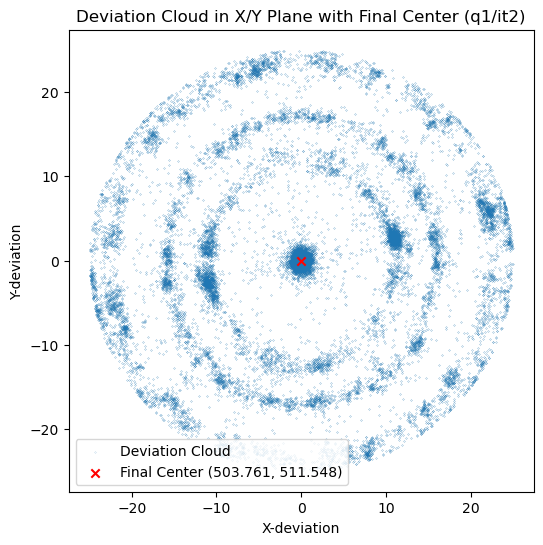

Quarter 1 processed in 1 iterations, final center = [503.761, 511.548], mean deviation = [2.001e-03,4.167e-03]


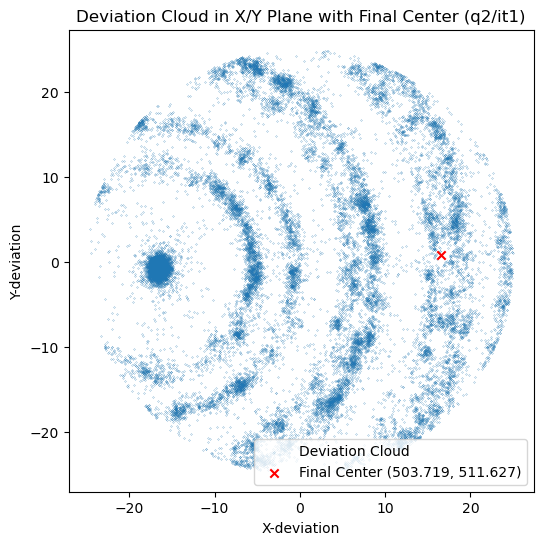

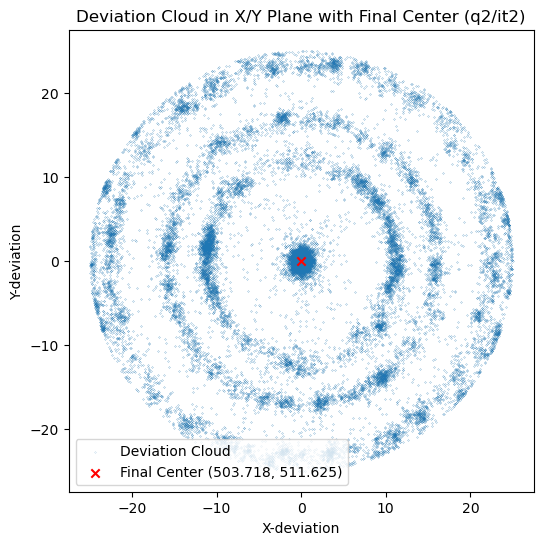

Quarter 2 processed in 1 iterations, final center = [503.718, 511.625], mean deviation = [2.018e-03,4.661e-03]


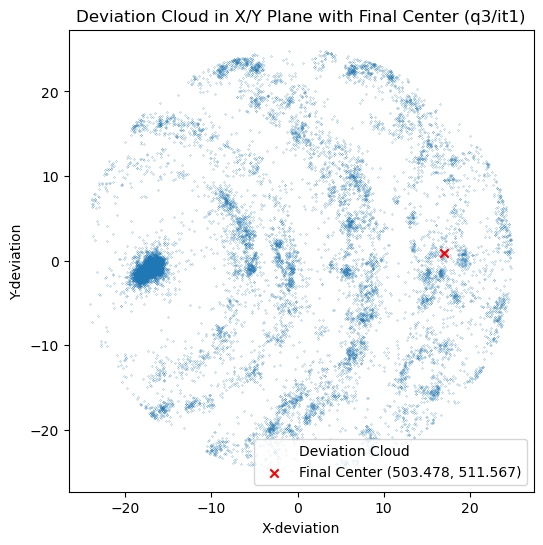

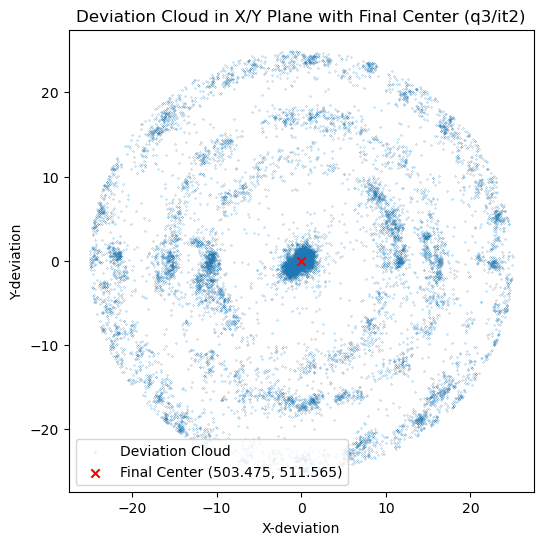

Quarter 3 processed in 1 iterations, final center = [503.475, 511.565], mean deviation = [6.412e-03,4.807e-03]


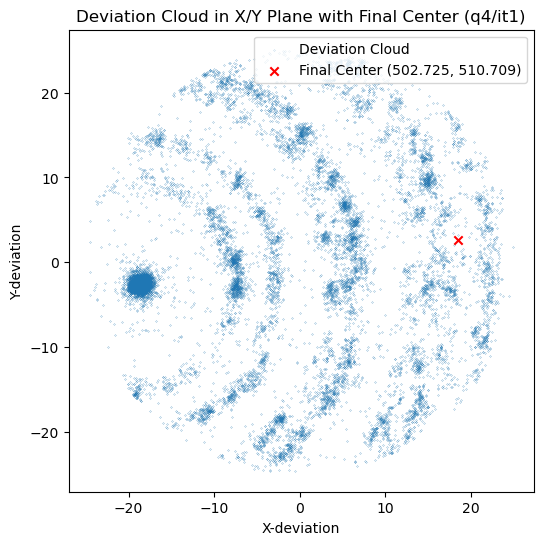

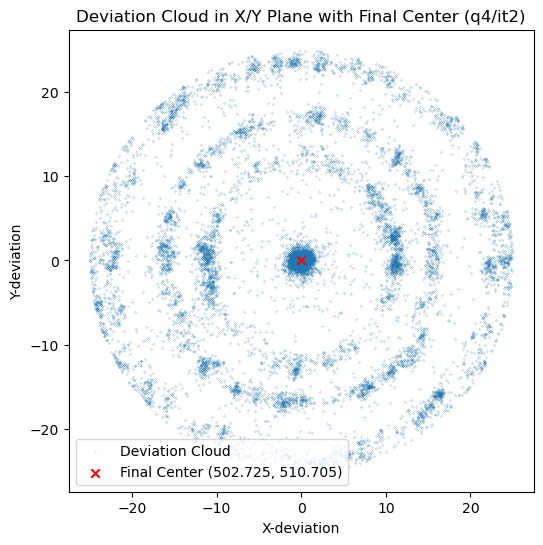

Quarter 4 processed in 1 iterations, final center = [502.725, 510.705], mean deviation = [1.191e-03,8.722e-03]
Interpolating centers based on linear fit
Scope of drift: 1.341 px in x, 1.037 px in y
Interpolated detector shifts written to HDF5 file


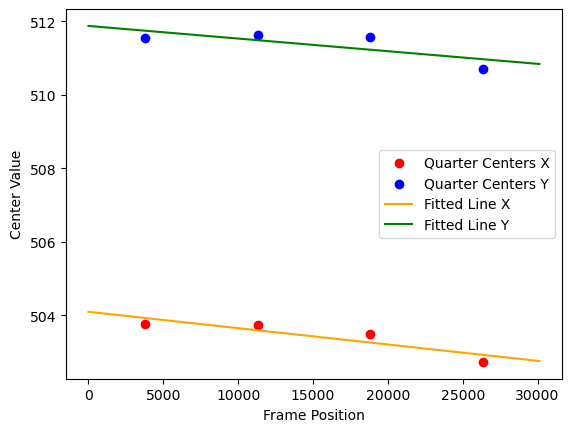

In [10]:
# Find Center Beam Spot Center
tolerance = 25 # If you know that your beam center is close to the center of the detector you can reduce the tolerance to reduce the processing time
min_peaks = 30 # Minimum number of peaks in a frame to be considered
resolution_limit = 150 # Maximum resultuion of peaks to be considered
min_samples_fraction = 0.05  # Fraction of datapoints in the largest cluster to be accepted
x0 = 512
y0 = 512

inputfolder_path= r"/mnt/c/Users/bubl3932/Desktop/TEST1b"

##### Enter parameters above #####

find_files_and_run_centerfinding(inputfolder_path, x0, y0, tolerance, min_peaks, resolution_limit, min_samples_fraction)

Lets improve the center beam center with a LOWESS fit

Working with R2aOx.h5
plotting LOWESS fit


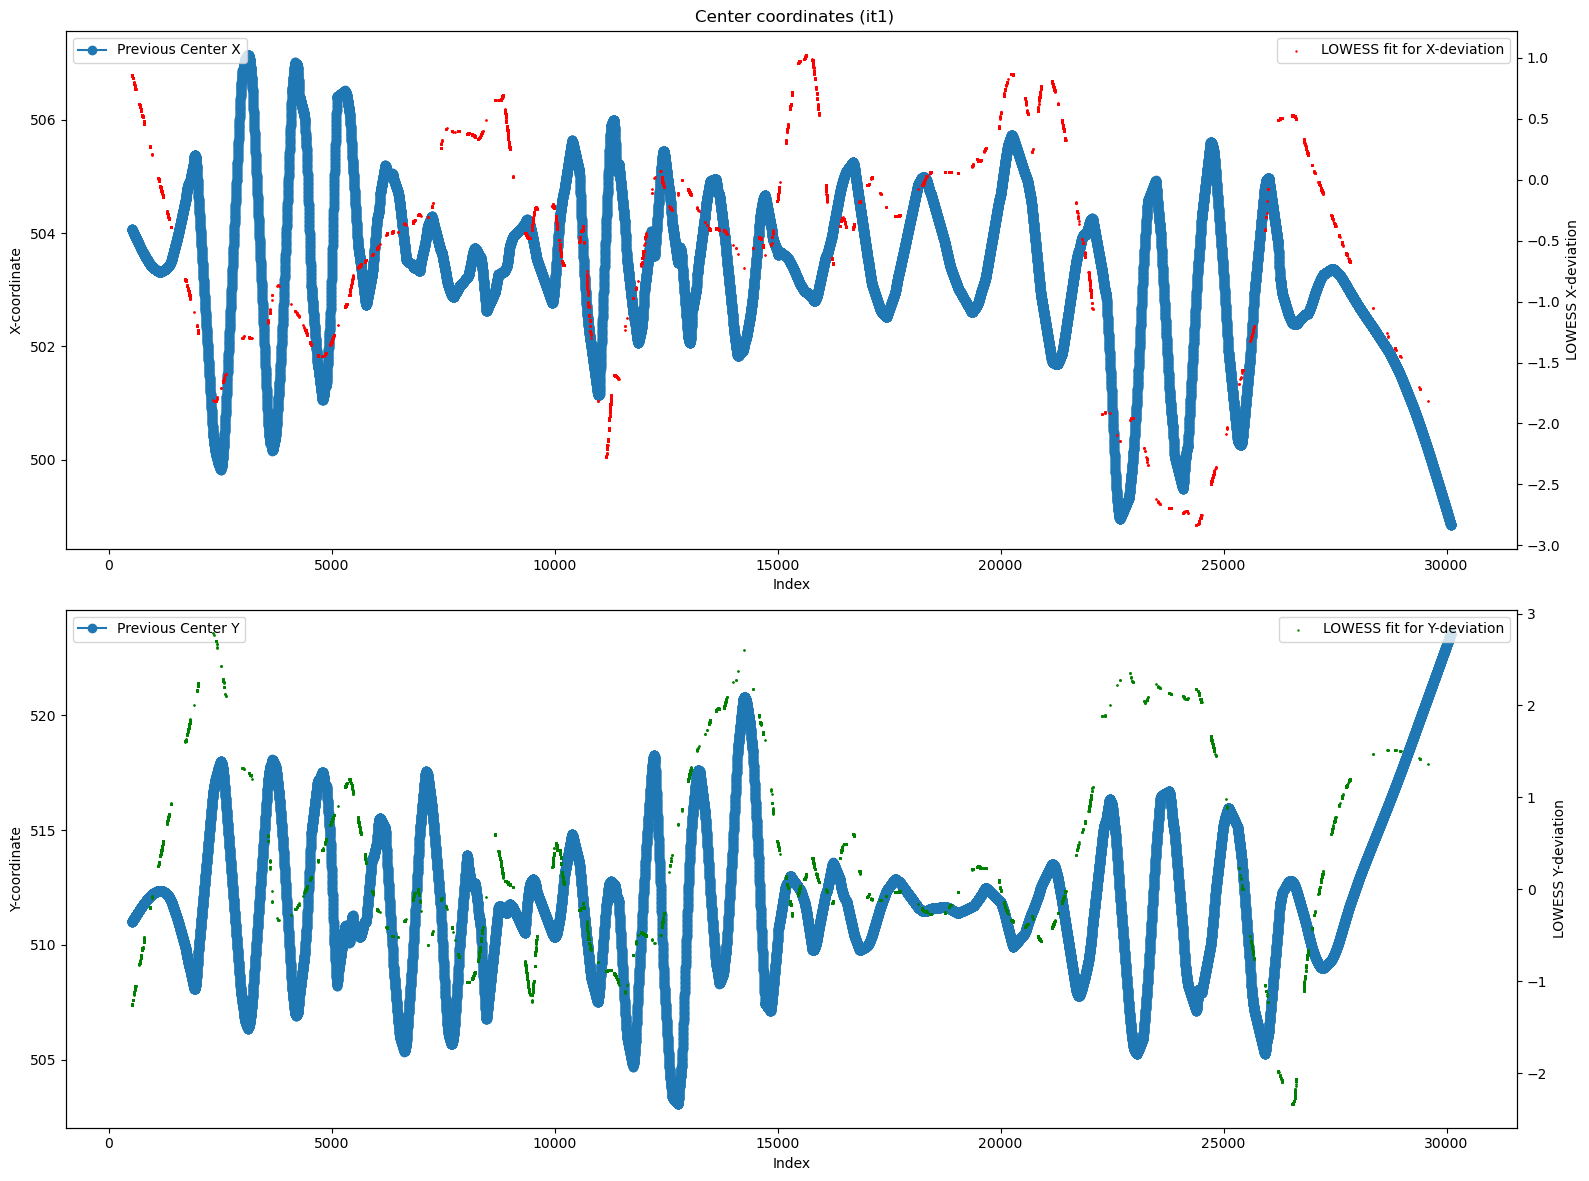

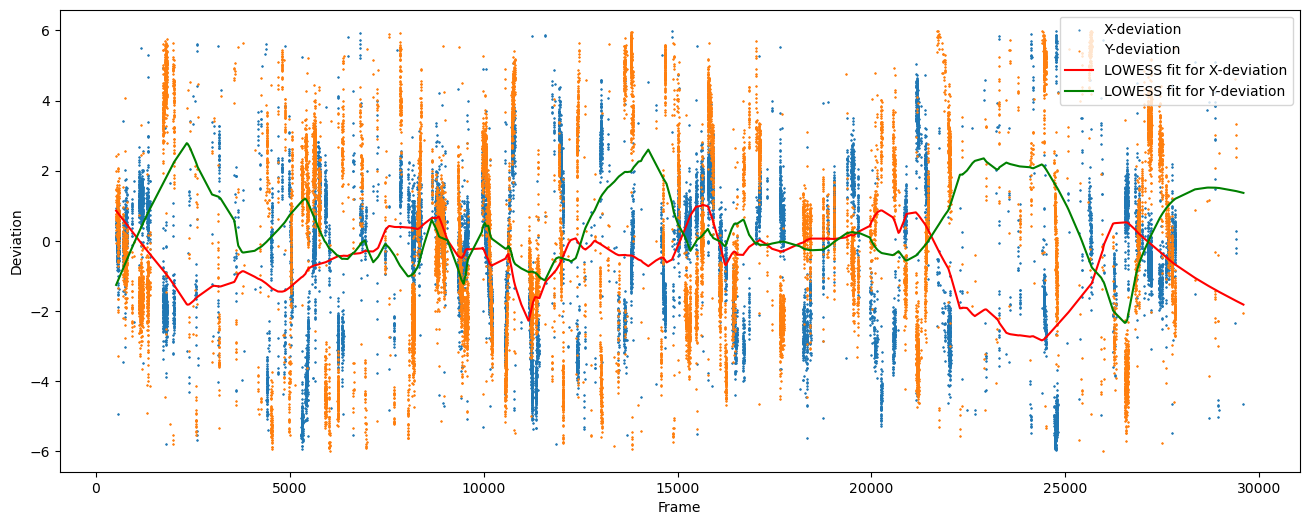

plotting LOWESS fit


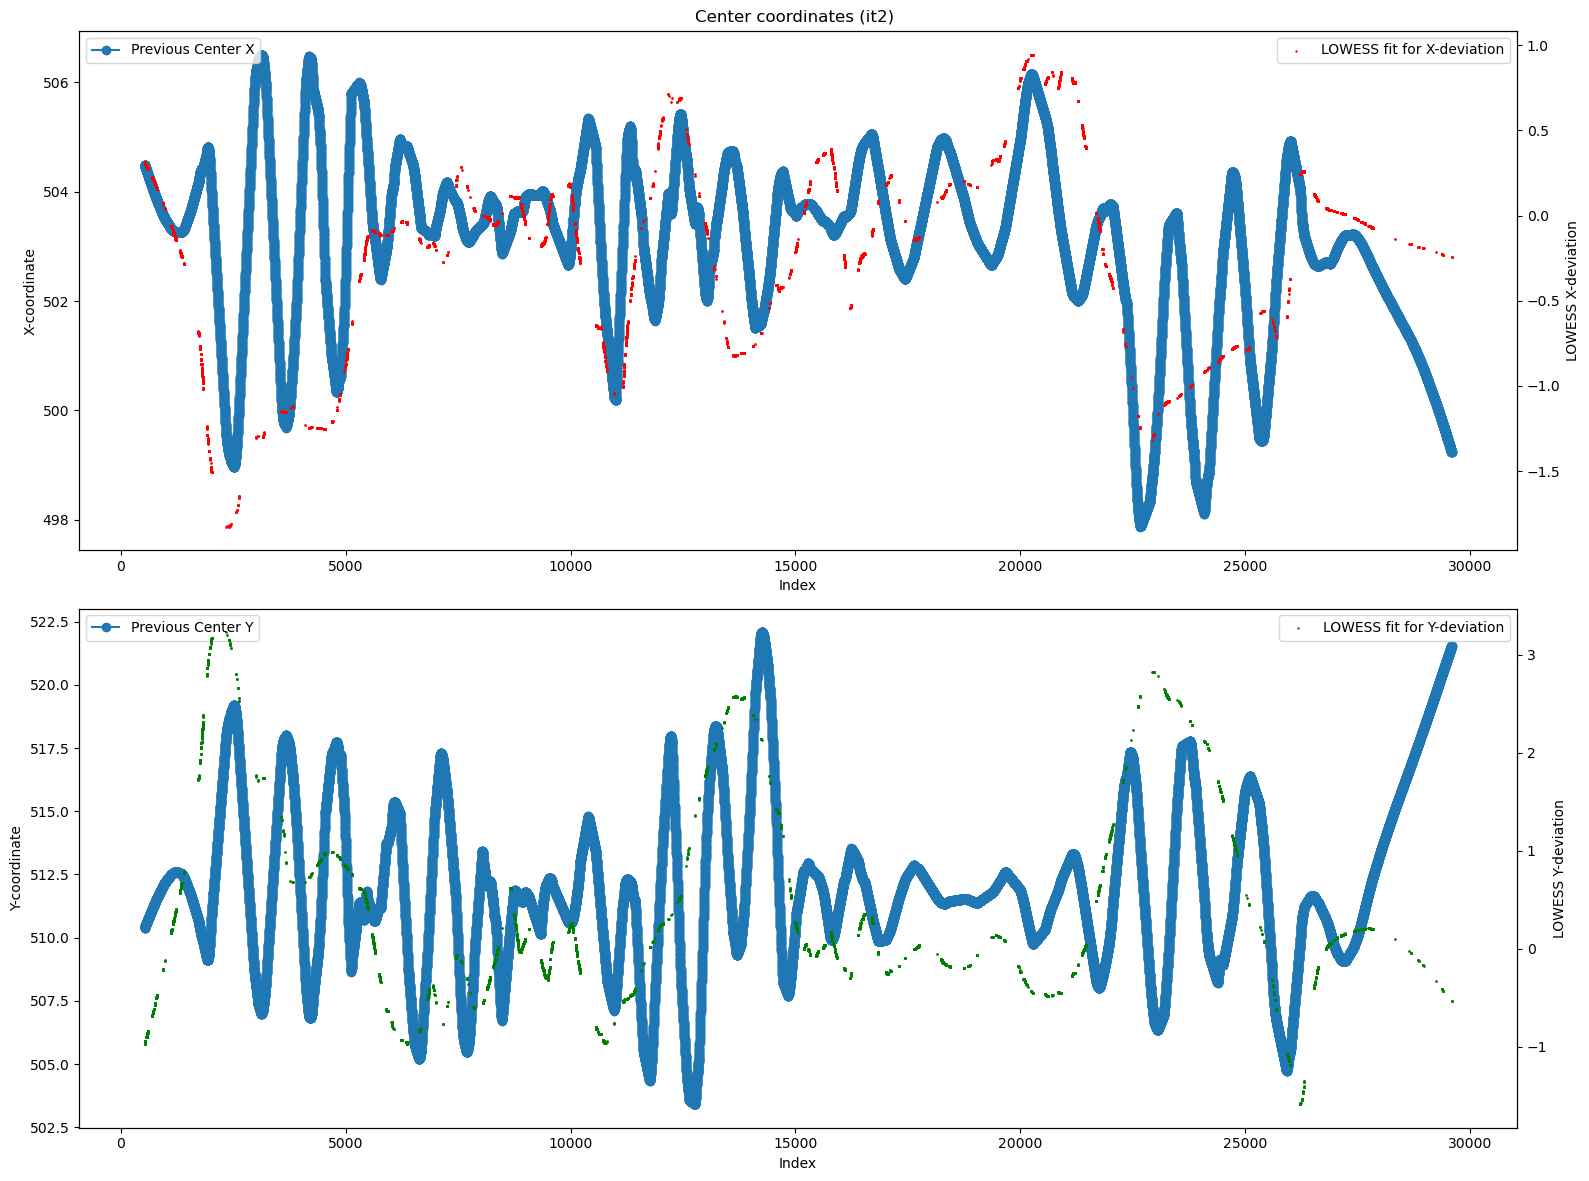

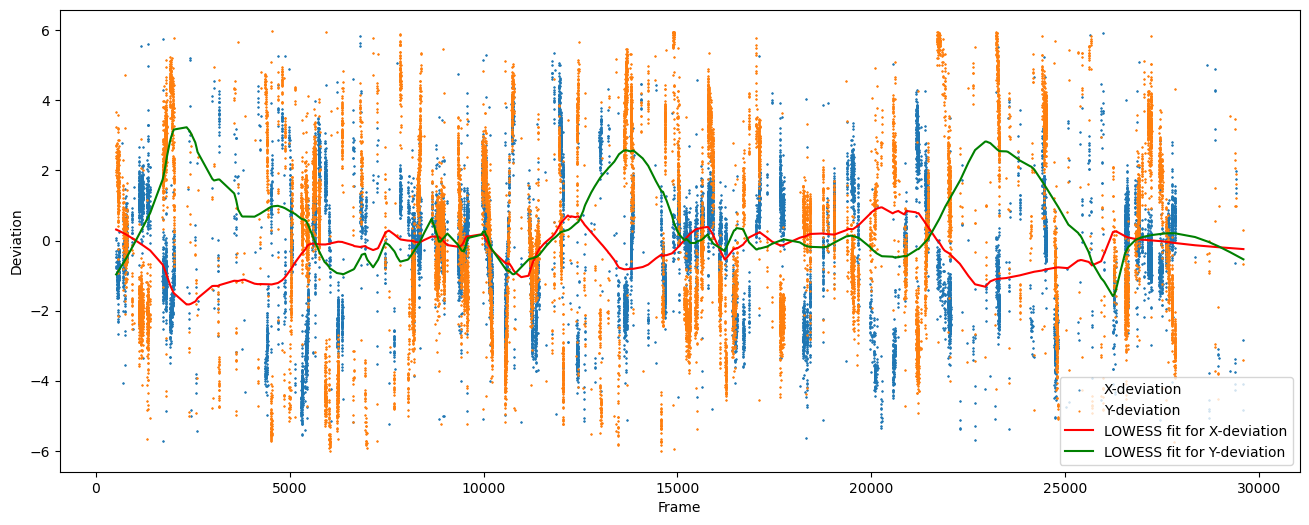

plotting LOWESS fit


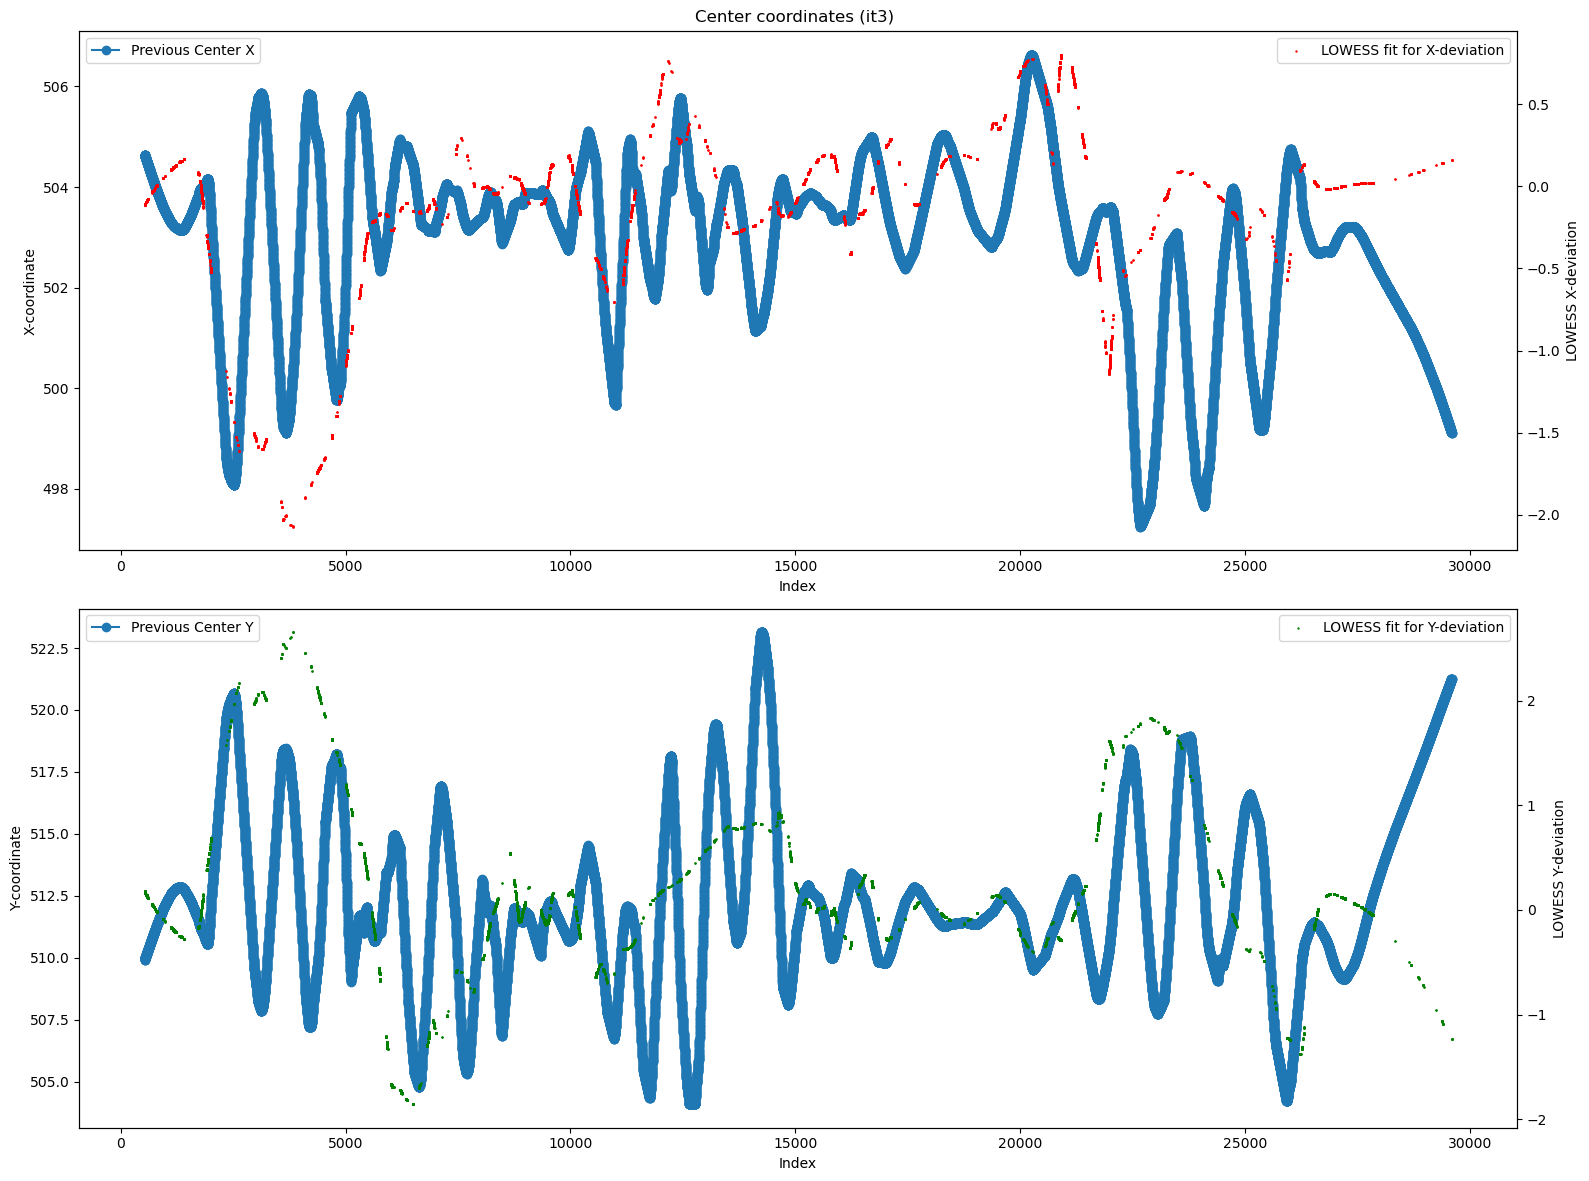

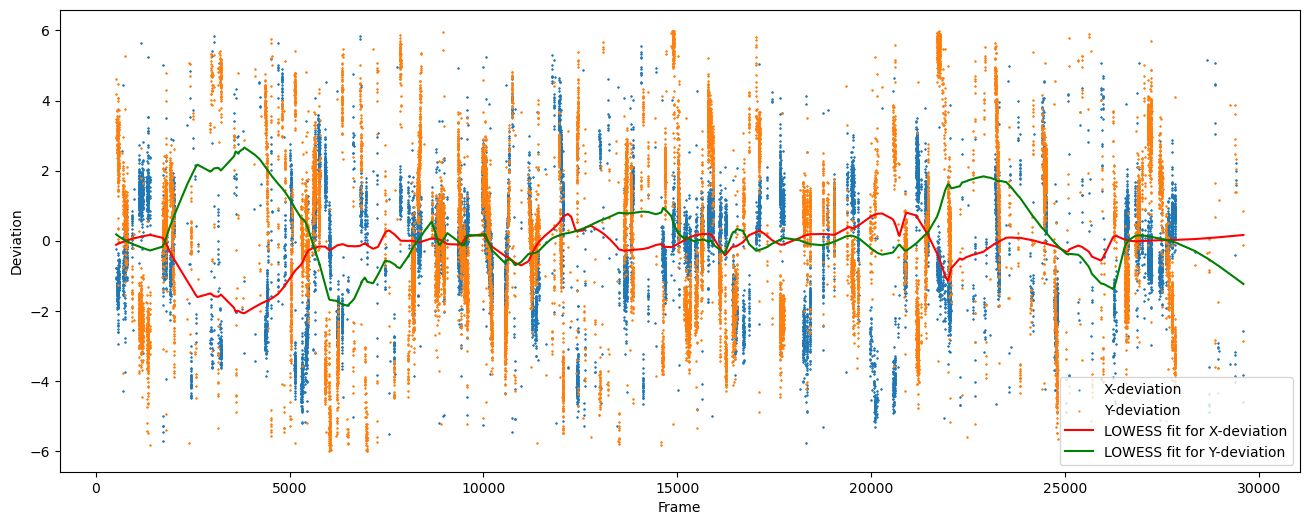

plotting LOWESS fit


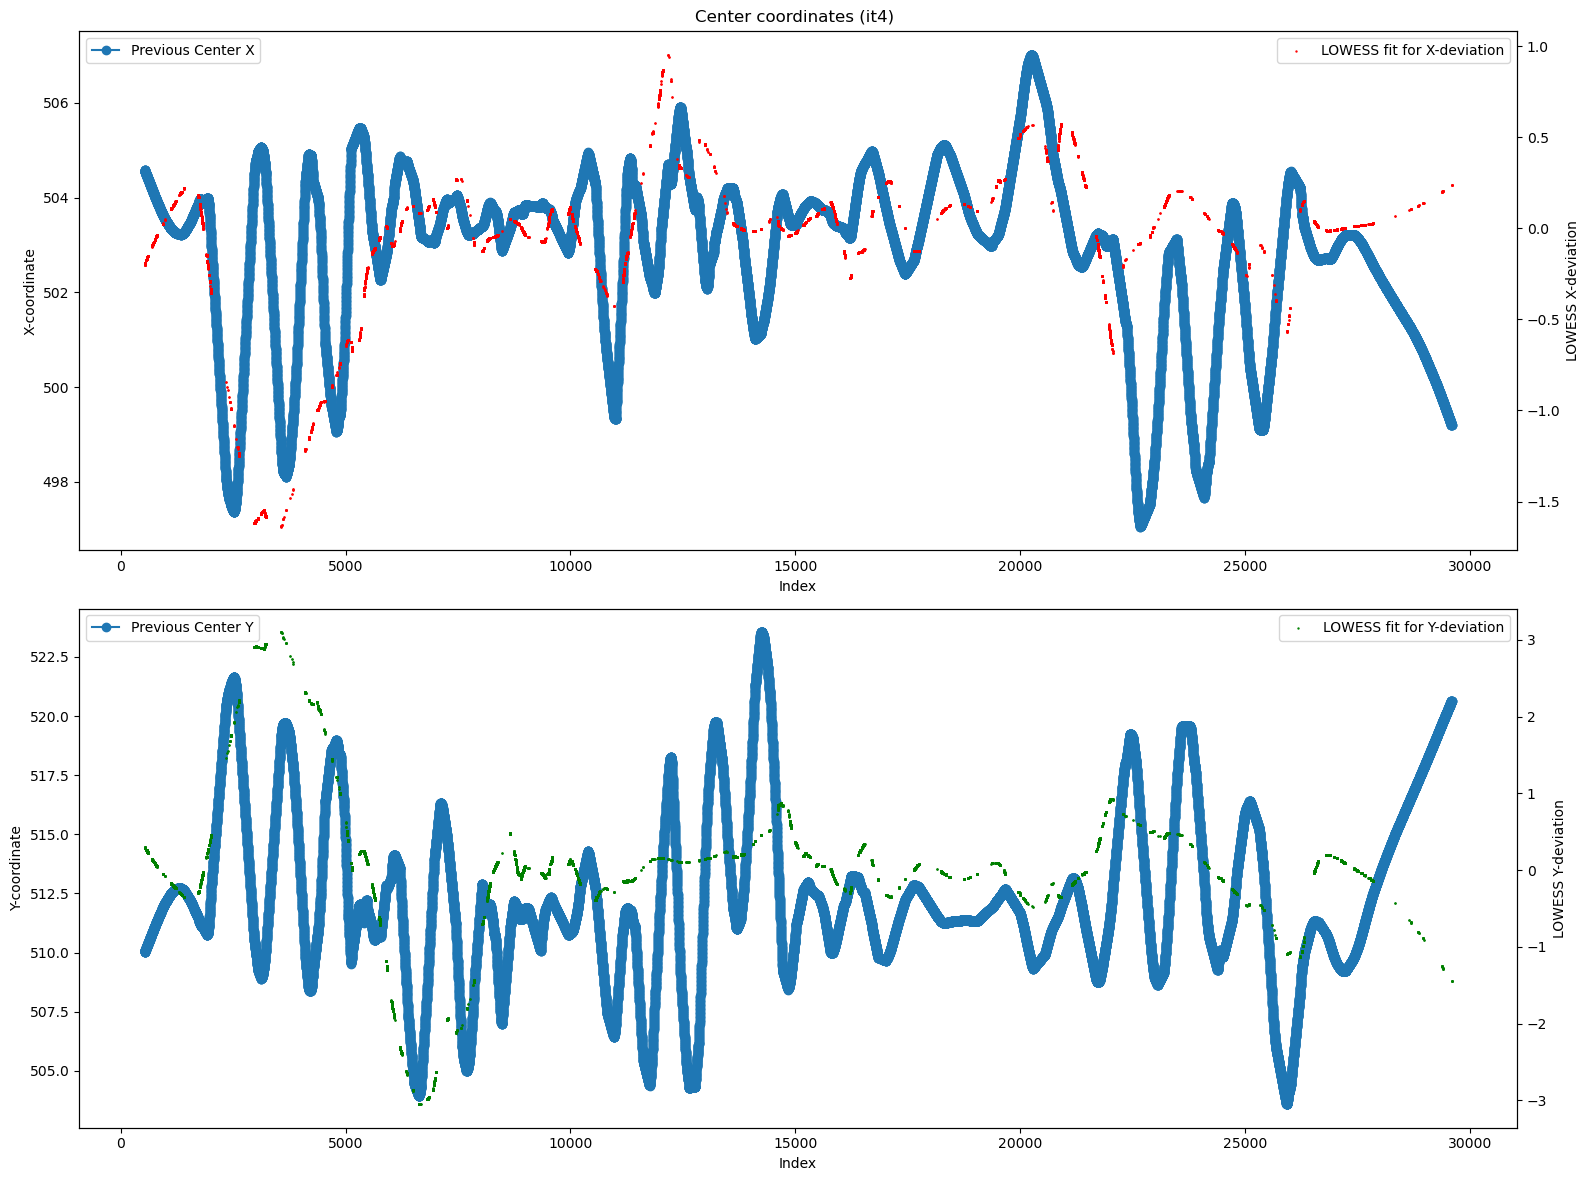

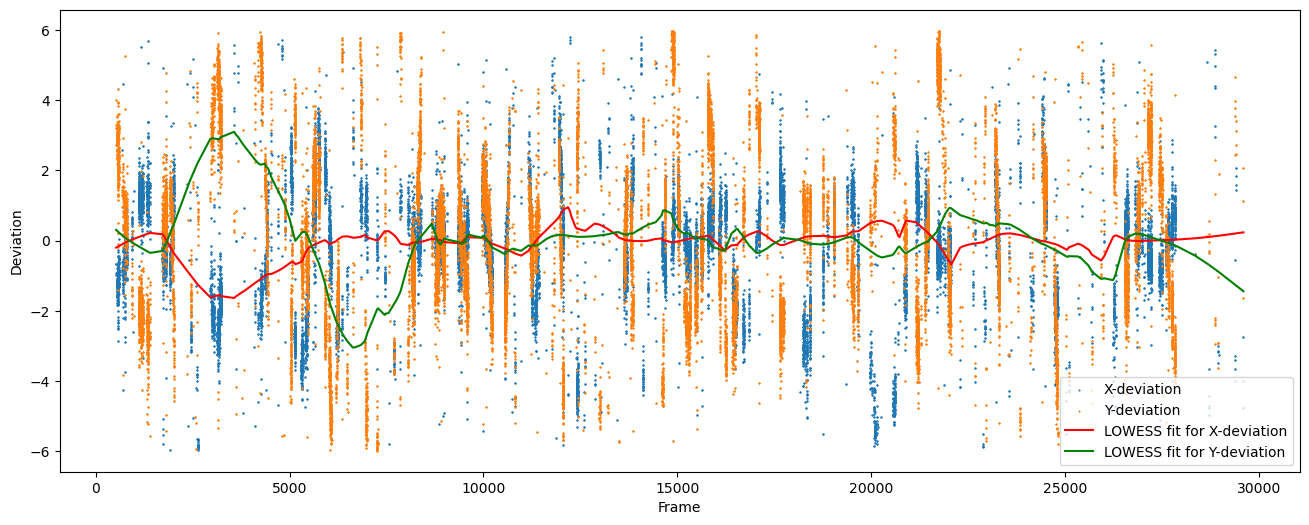

plotting LOWESS fit


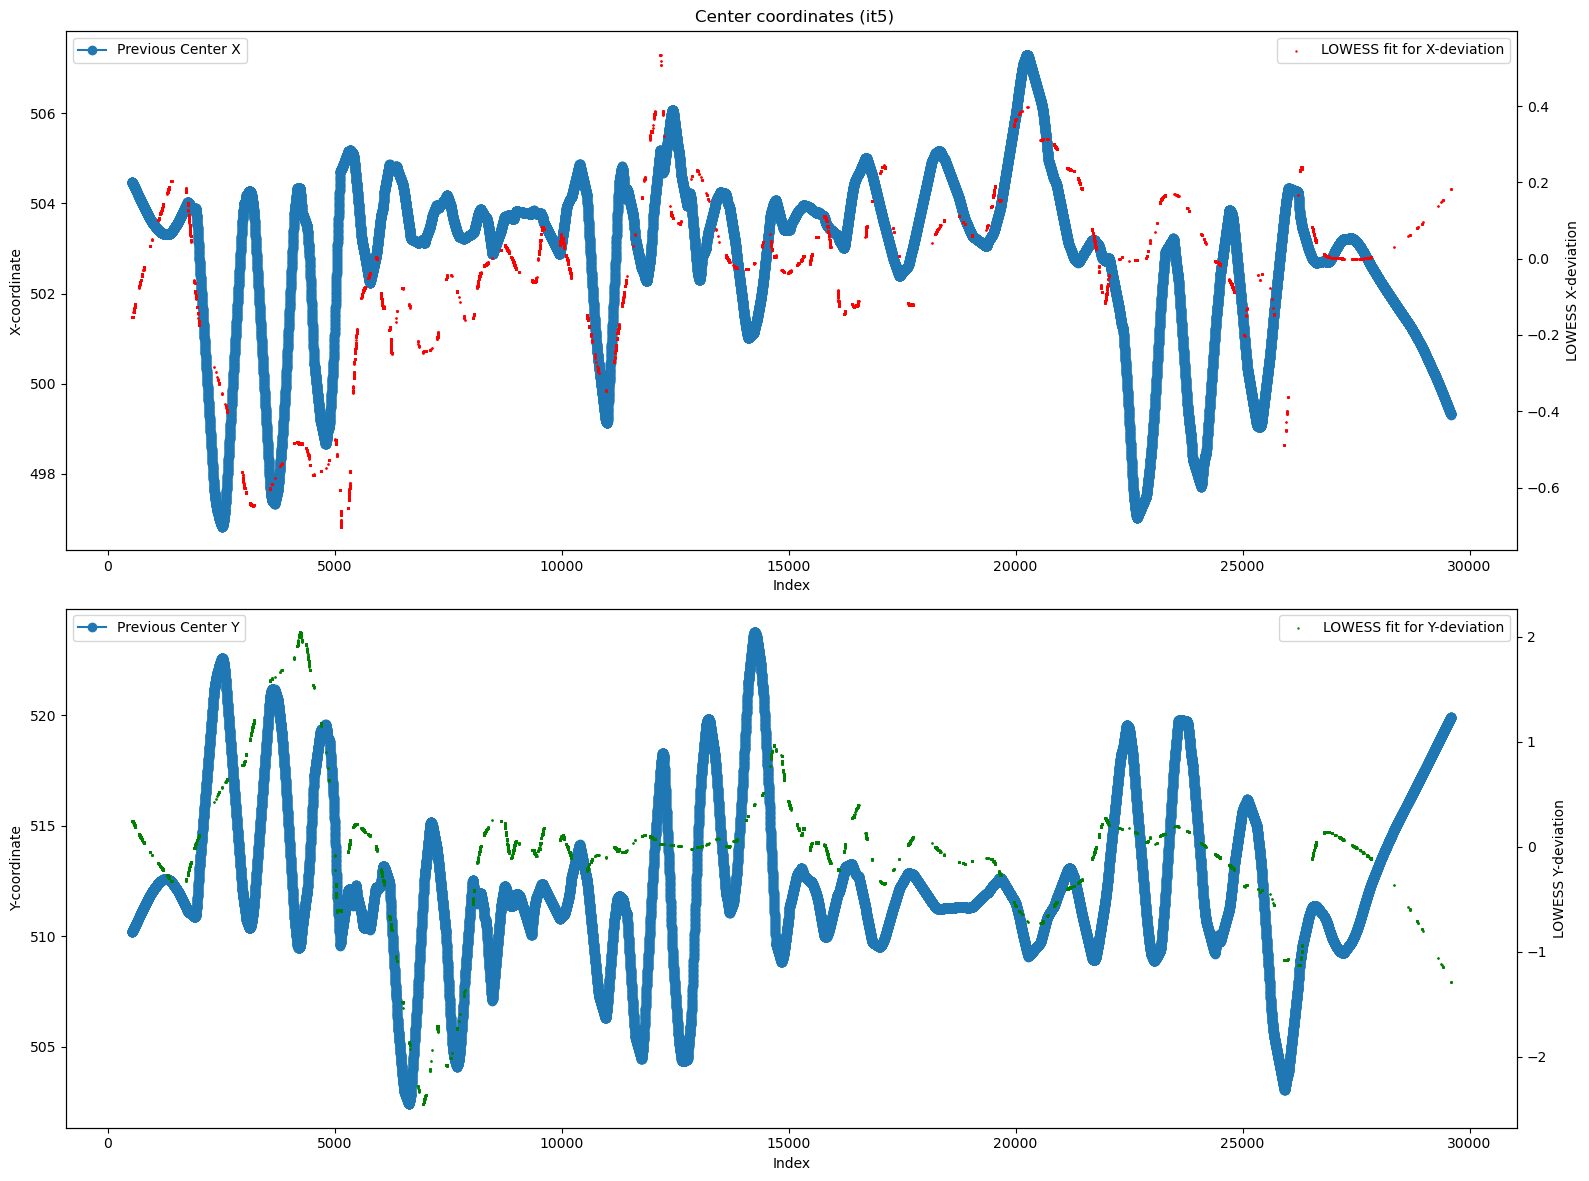

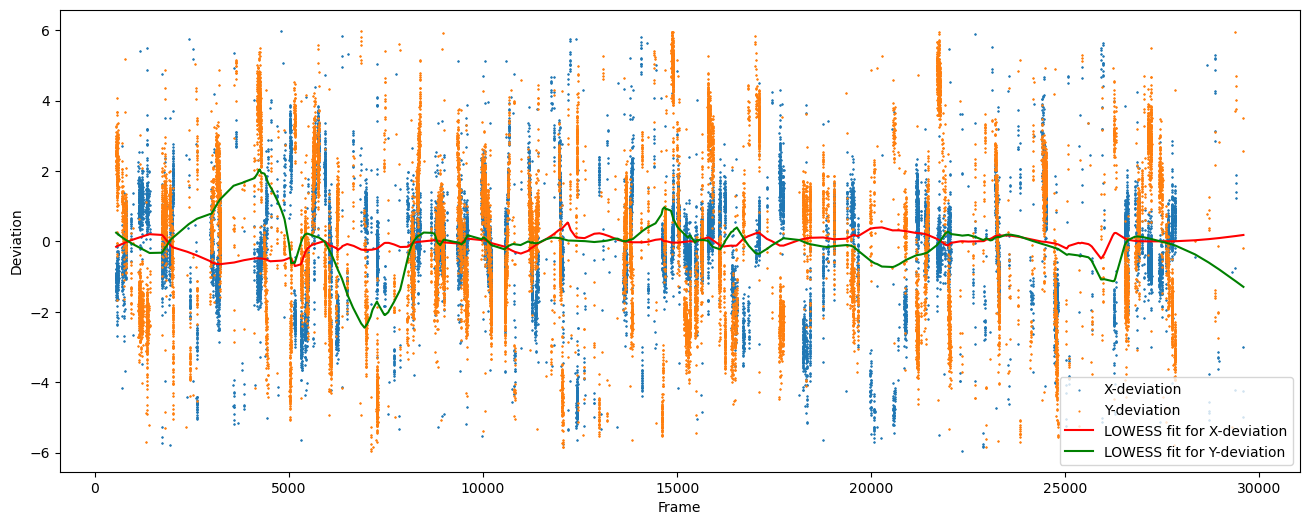

plotting LOWESS fit


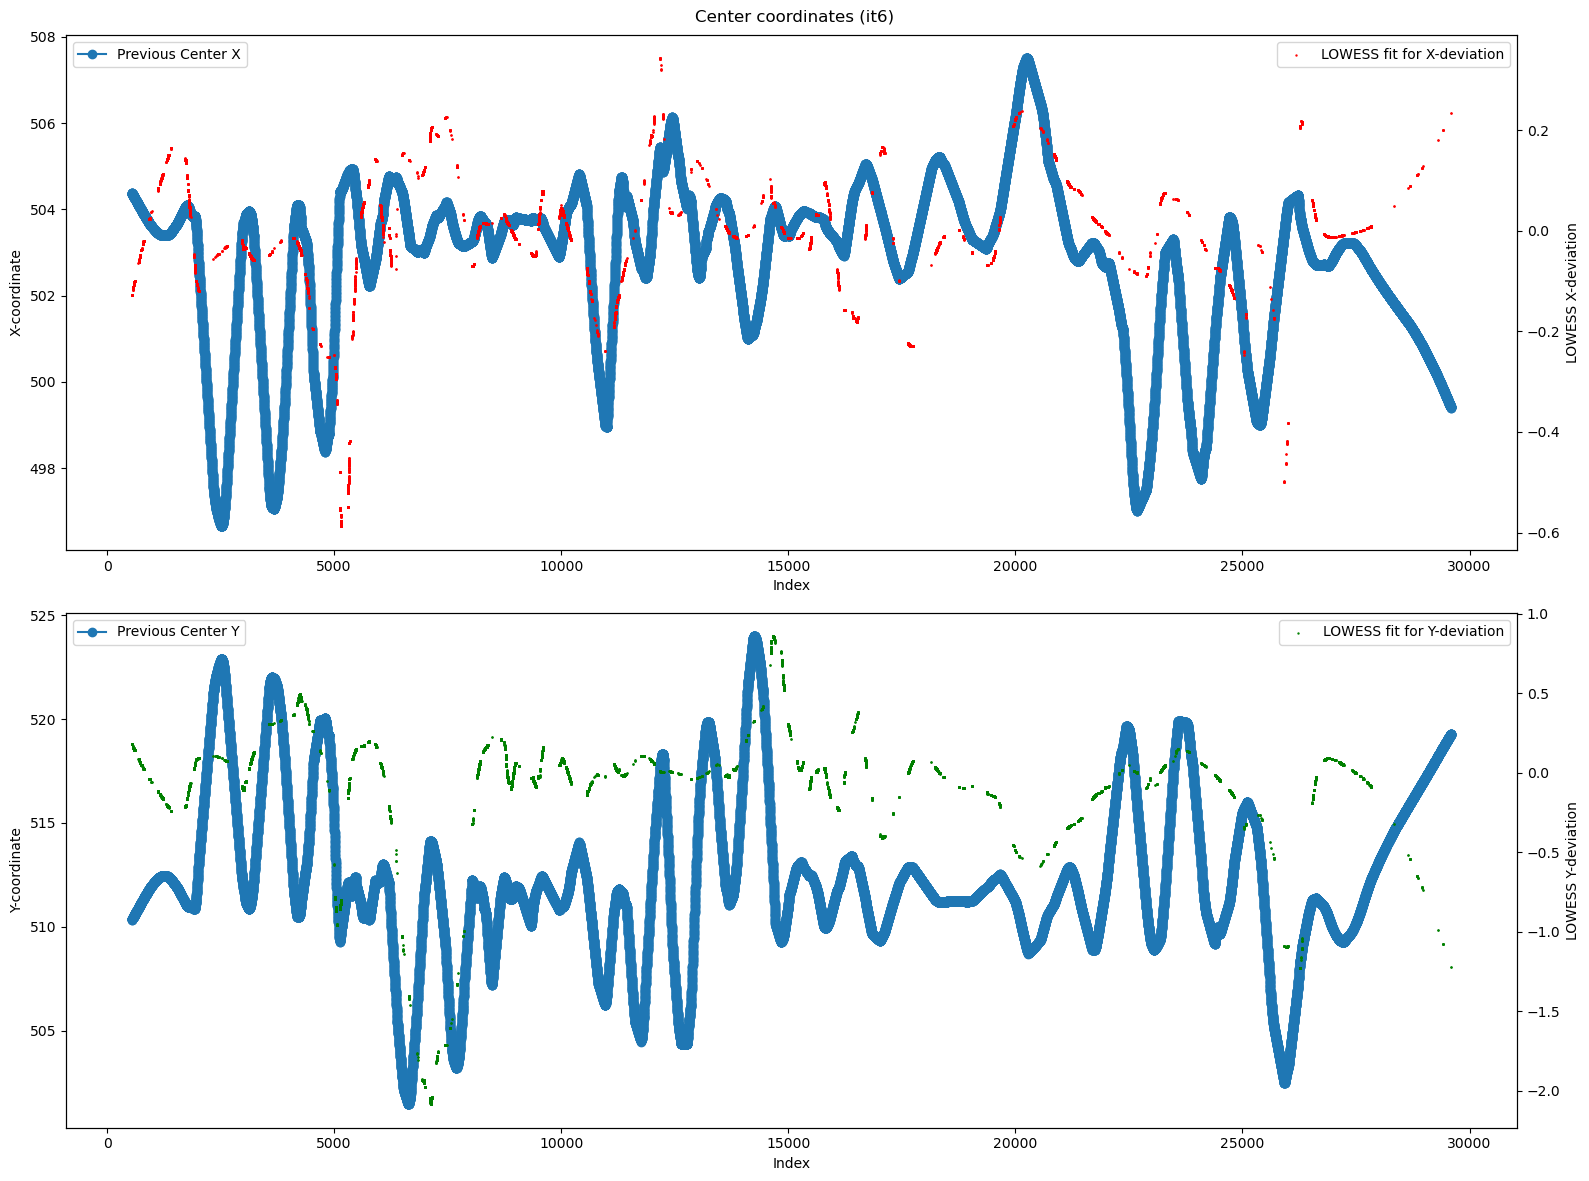

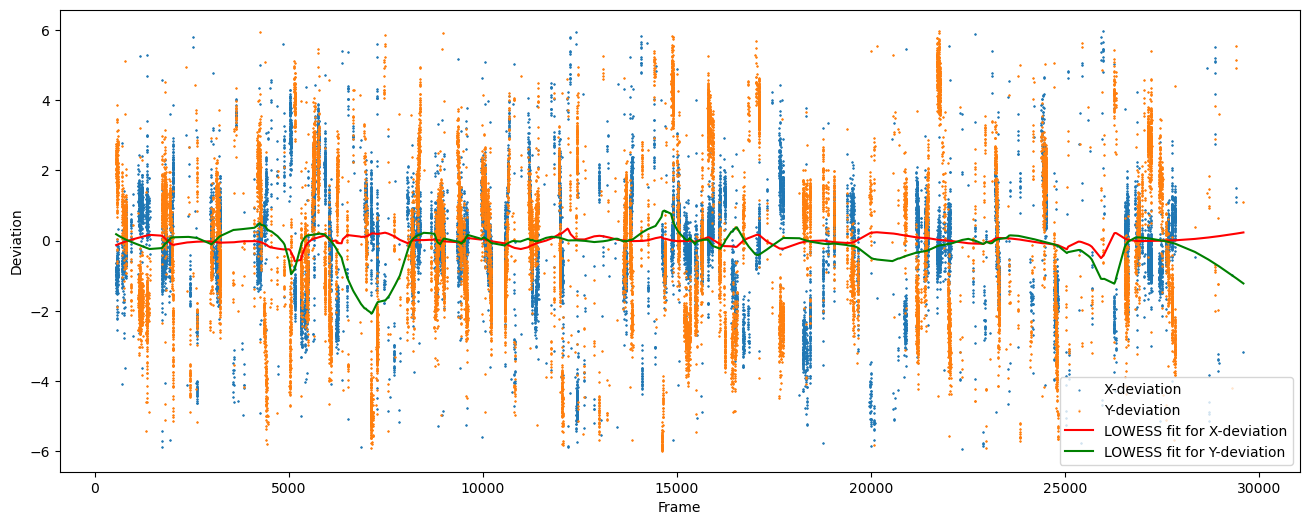

plotting LOWESS fit


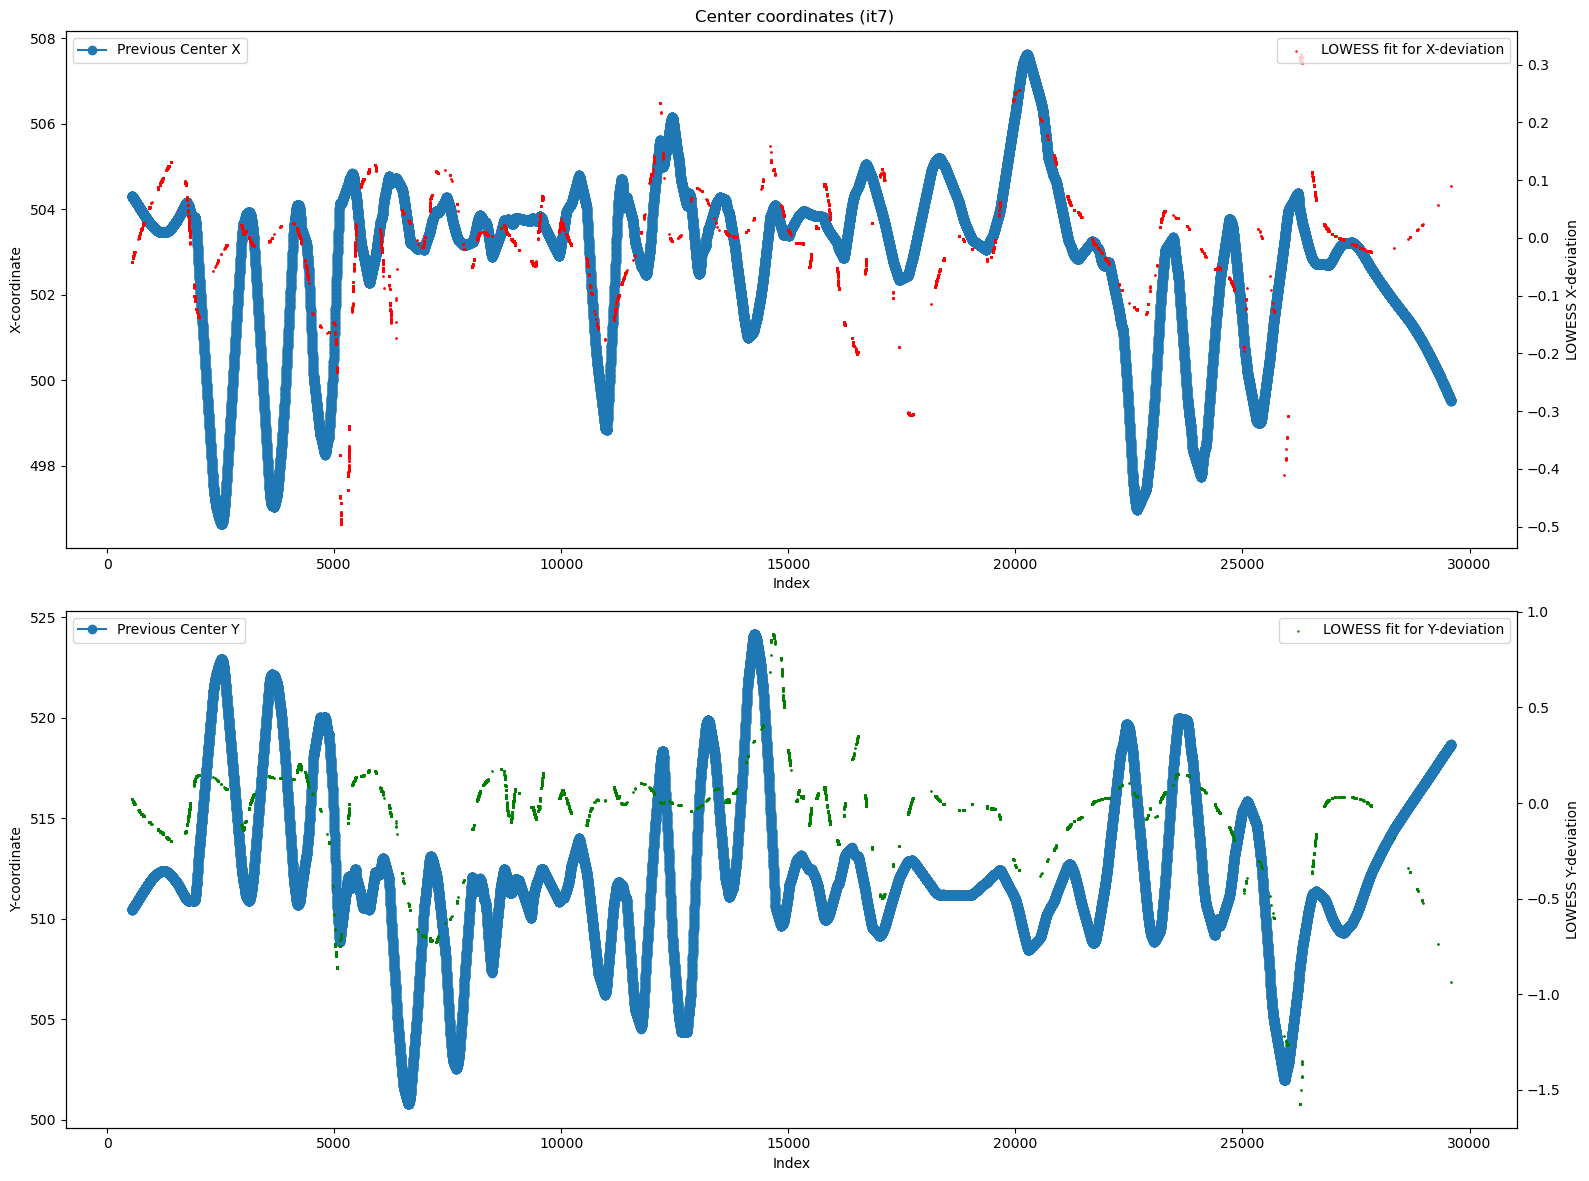

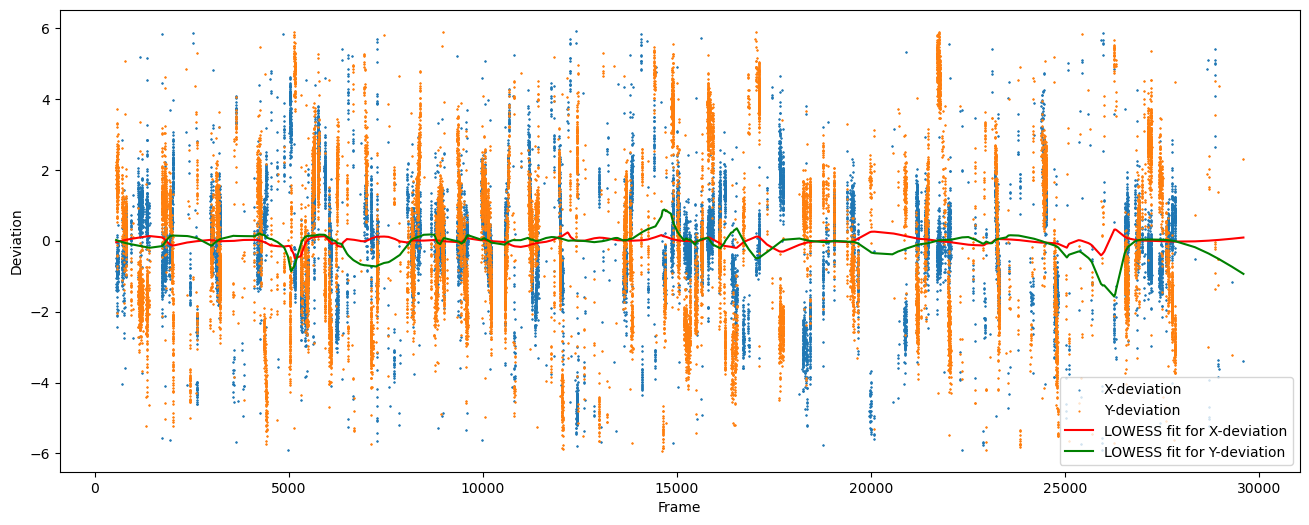

plotting LOWESS fit


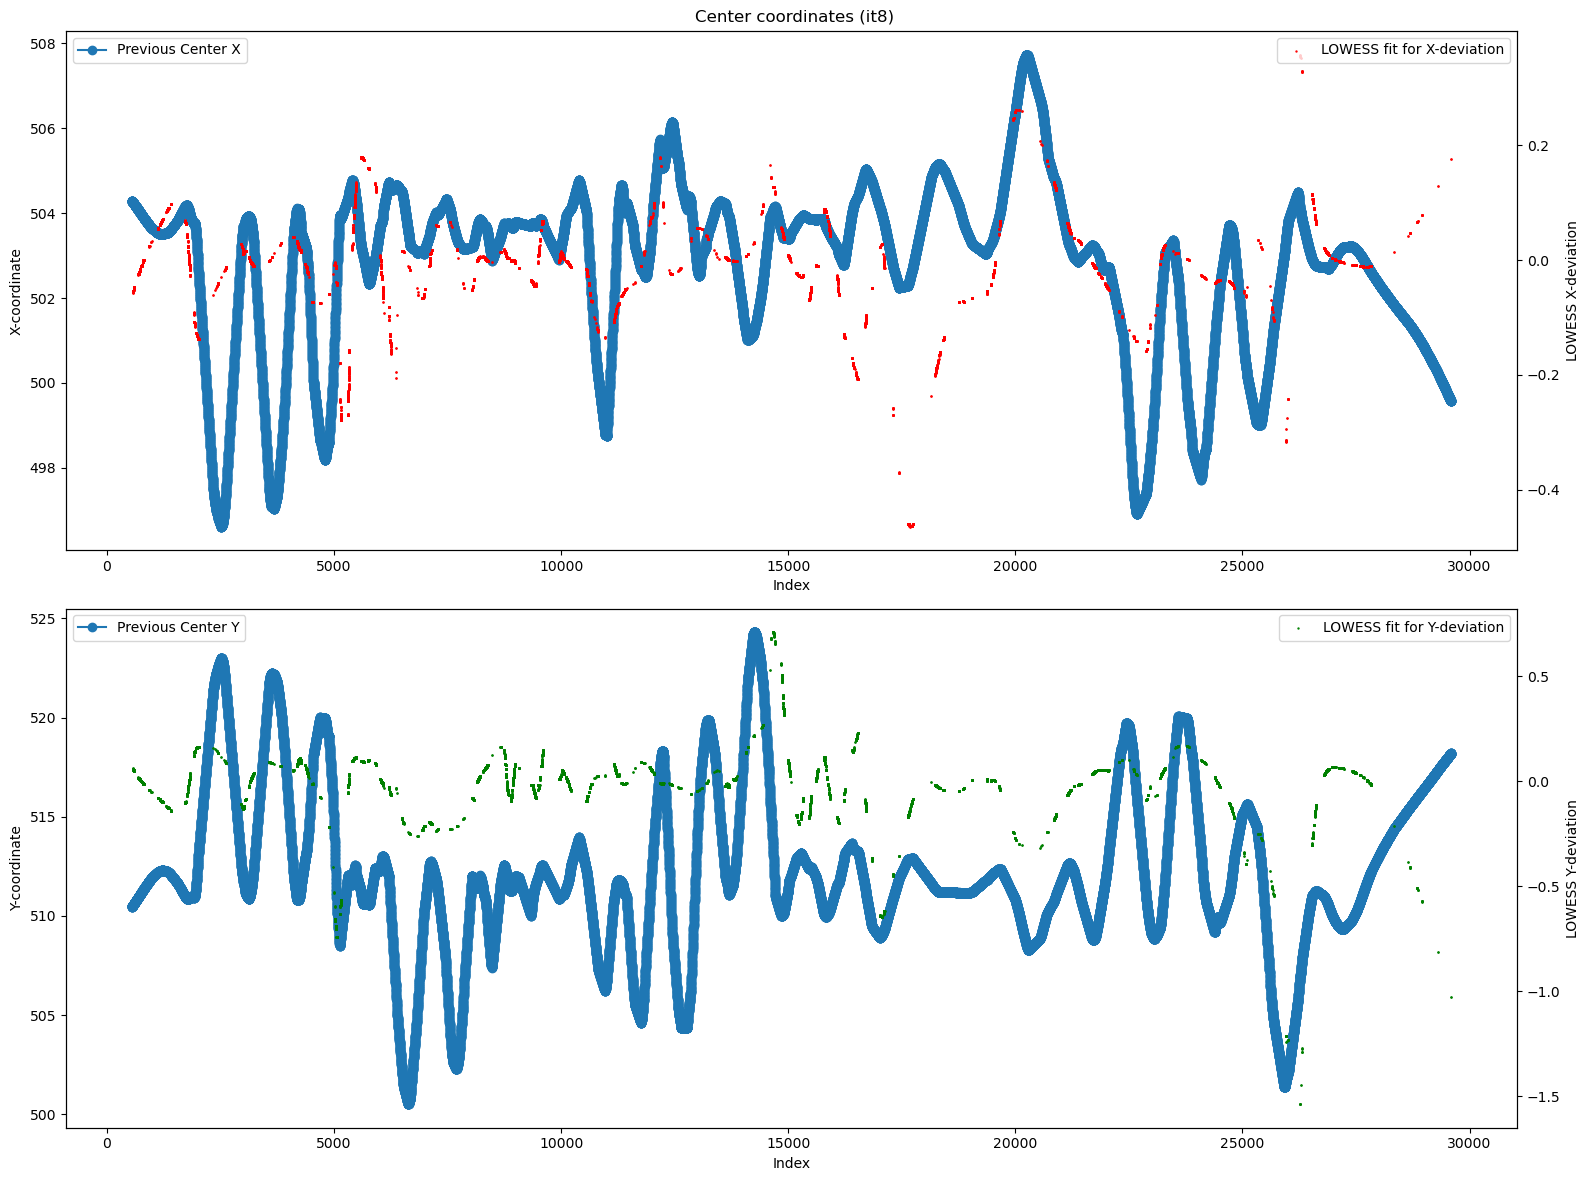

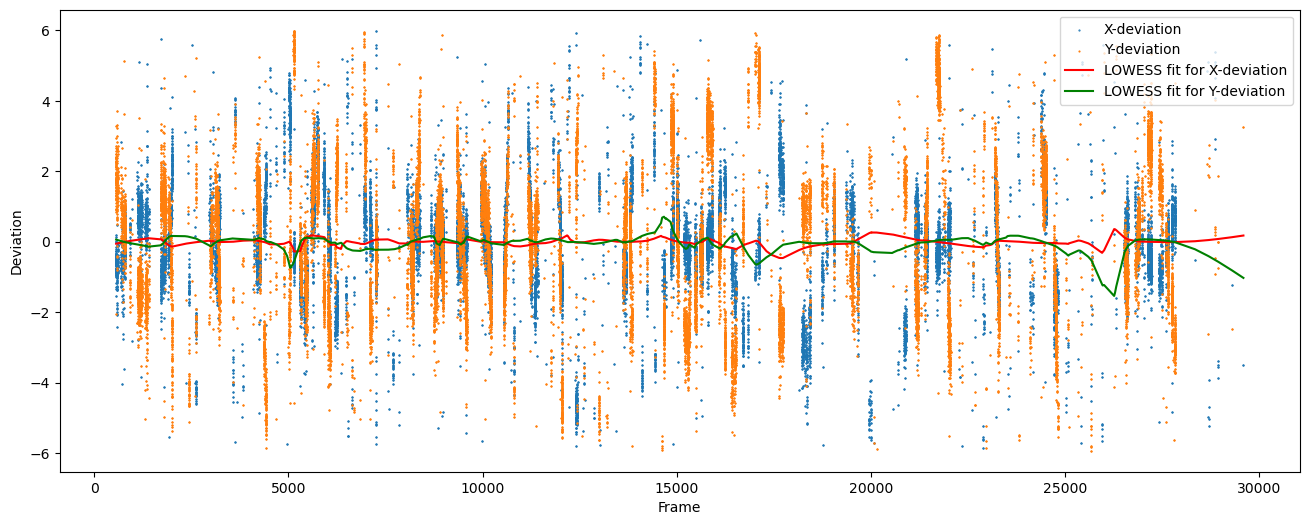

plotting LOWESS fit


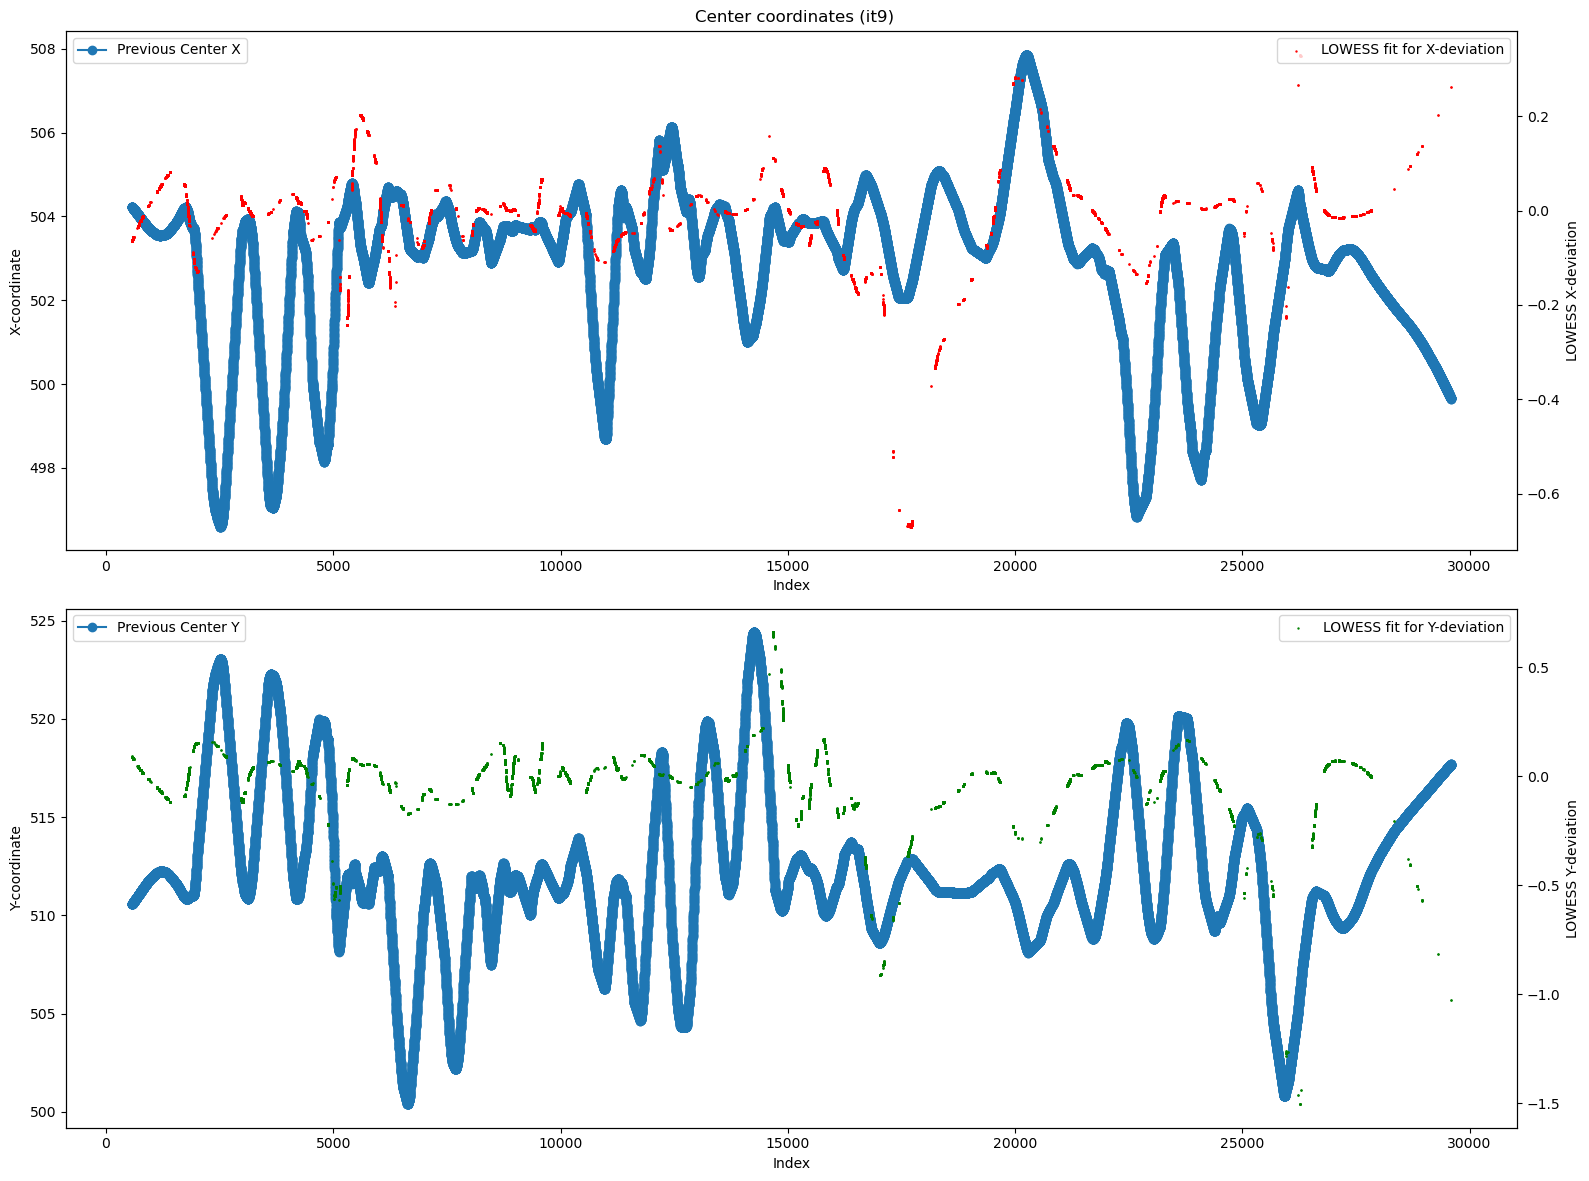

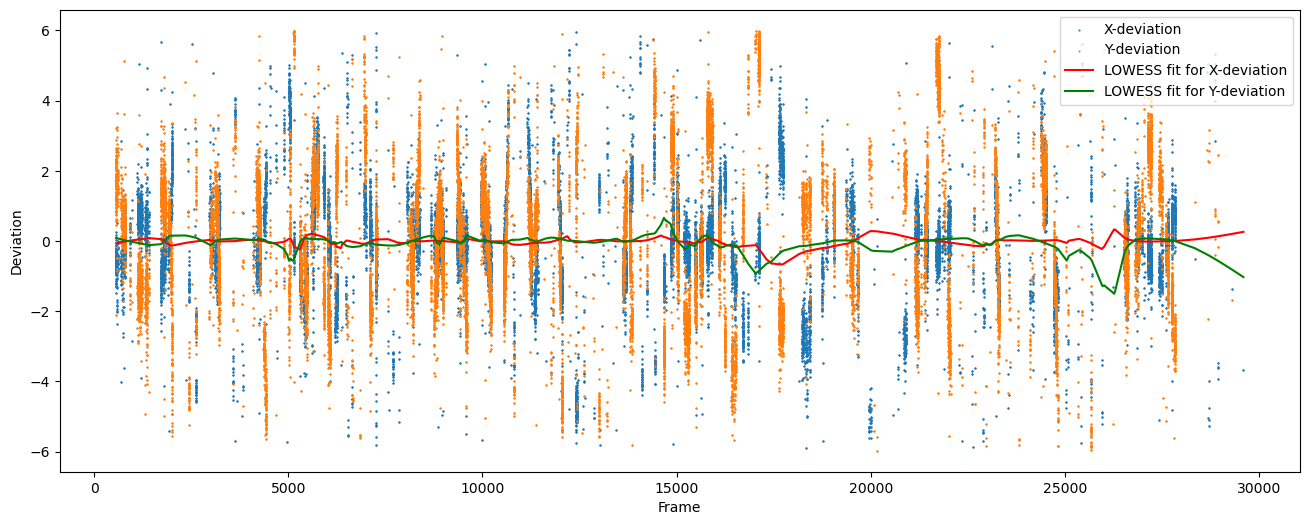

plotting LOWESS fit


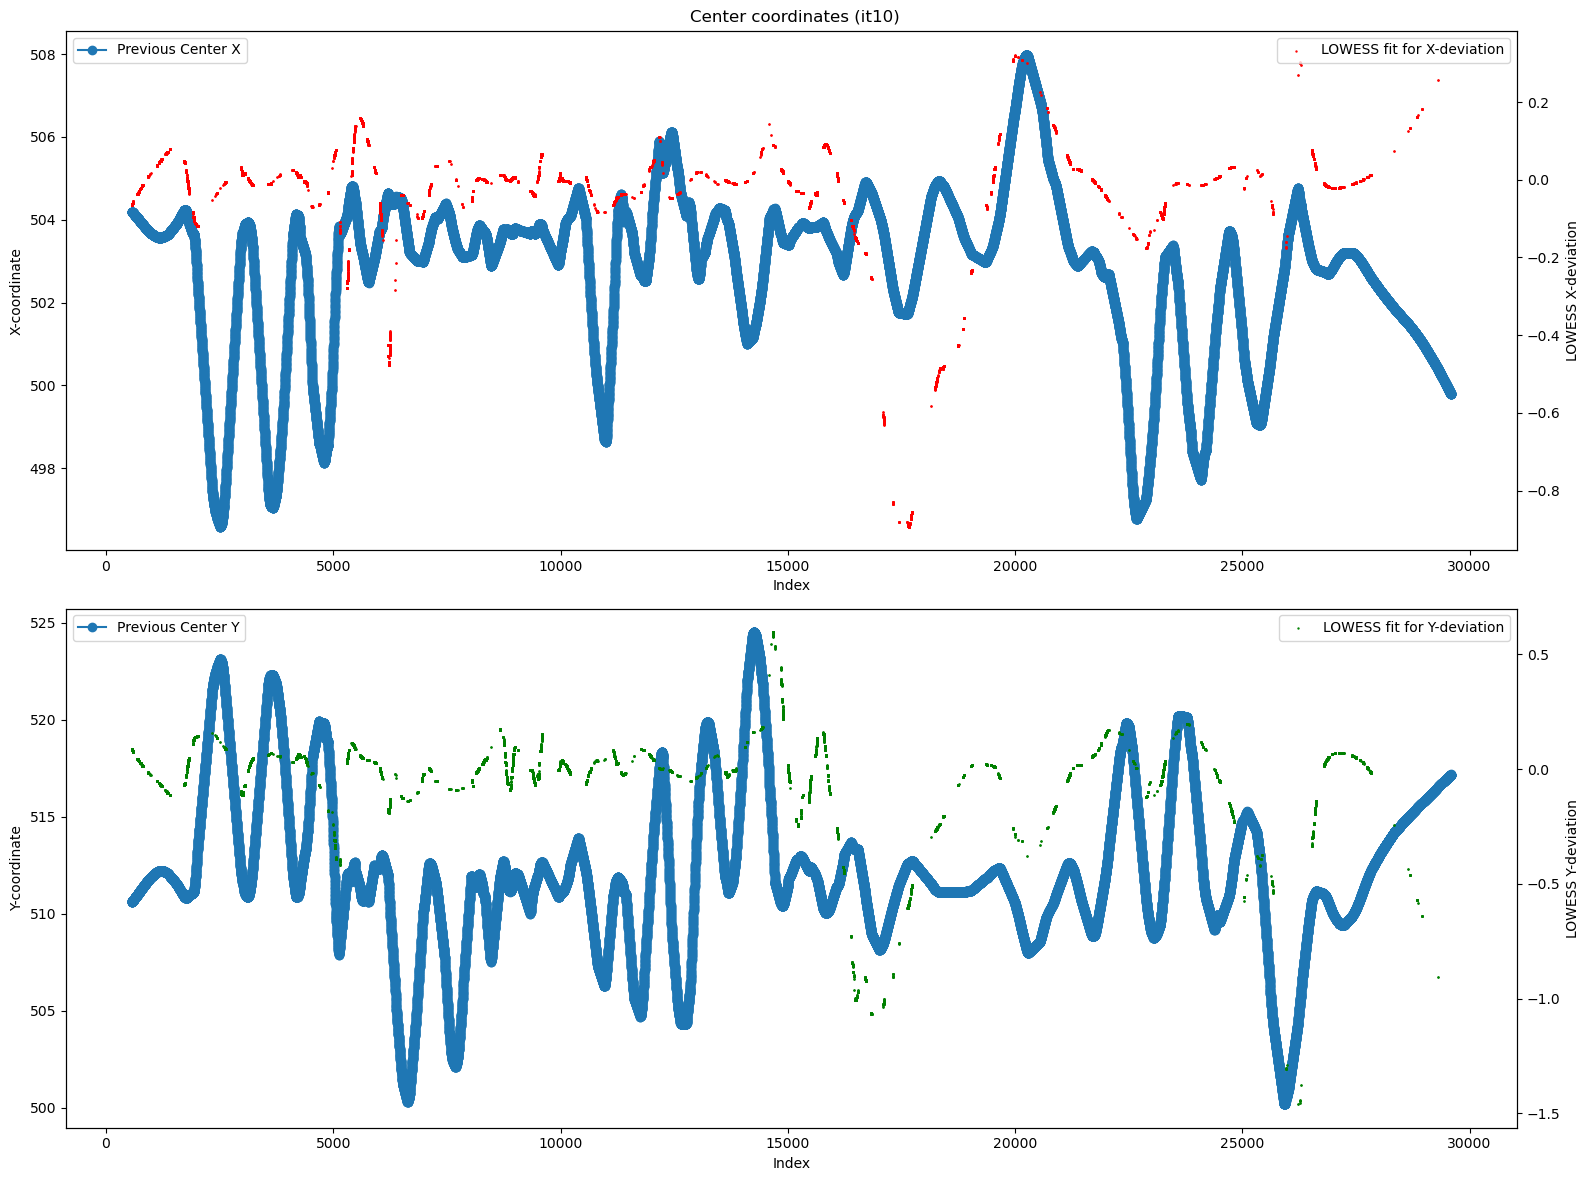

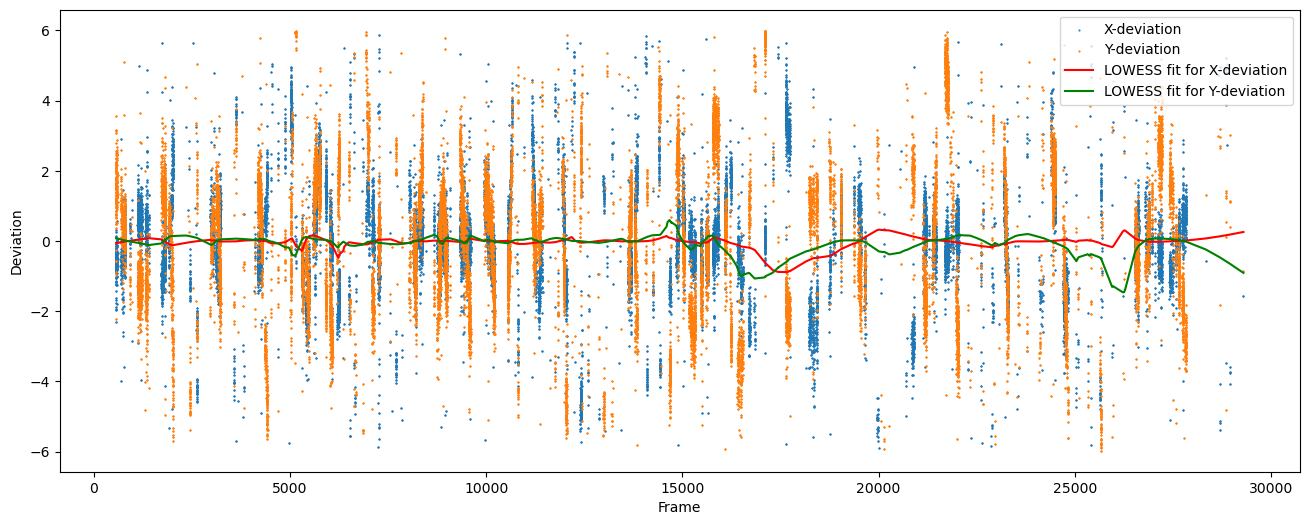

Could not meet convergenc criterion (0.05) after 10 iterations, refinement terminated
Updated detector shifts written to HDF5 file


In [17]:
# Center Beam Drift Refinement
tolerance = 6 # If you know that your beam center is close to the center of the detector you can reduce the tolerance to reduce the processing time
min_peaks = 20  # Minimum number of peaks per frame to be used for refinement
resolution_limit = 150 # Maximum resolution of peaks to be considered for refinement
max_iterations = 10 # Maximum number of iterations for refinement
convergence_threshold = 0.05 # Refinement is stopped when the deviation of the LOWESS fit does not exceed the threshold (given in pixels)

inputfolder_path= r"/mnt/c/Users/bubl3932/Desktop/TEST1b"

##### Enter your parameters above #####

find_files_and_run_centerrefinement(inputfolder_path, tolerance, min_peaks, resolution_limit, max_iterations, convergence_threshold)

And now to find the indexing using xGandalf (5x5=25 output streams)

In [3]:
# Indexing
geomfile_path = r"/mnt/c/Users/bubl3932/Desktop/TEST1b/R2aOx.geom"
cellfile_path = r"/mnt/c/Users/bubl3932/Desktop/TEST1b/R2aOx.cell"
input_path = r"/mnt/c/Users/bubl3932/Desktop/TEST1b"
output_file_base = "TEST1b-R2aOx"

num_threads = 23
indexing_method = "xgandalf"
resolution_push = 0
integration_method = "rings"
int_radius = "4,5,8"
min_peaks = 15
xgandalf_tolerance = 0.02
xgandalf_sampling_pitch = 5
xgandalf_min_vector_length = 40
xgandalf_max_vector_length = 110
xgandalf_iterations = 1
tolerance = "5,5,5,5"

##### Enter your parameters above #####

gandalf_iterator(geomfile_path, cellfile_path, input_path, output_file_base, num_threads, indexing_method, resolution_push, integration_method, int_radius, min_peaks, xgandalf_tolerance, xgandalf_sampling_pitch, xgandalf_min_vector_length, xgandalf_max_vector_length, xgandalf_iterations, tolerance)

Running for initial x=-512, y=-512


This is what I understood your unit cell to be:
orthorhombic P, right handed.
a      b      c            alpha   beta  gamma
 74.62  77.24 144.81 A     90.00  90.00  90.00 deg
List of indexing methods:
   0: xgandalf-nolatt-cell      (xgandalf using cell parameters as prior information)
Indexing parameters:
                  Check unit cell parameters: on
                        Check peak alignment: on
                   Refine indexing solutions: off
 Multi-lattice indexing ("delete and retry"): on
                              Retry indexing: off
780 images processed, 104 hits (13.3%), 11 indexable (10.6% of hits, 1.4% overall), 11 crystals, 148.8 images/sec.
1604 images processed, 192 hits (12.0%), 42 indexable (21.9% of hits, 2.6% overall), 42 crystals, 125.1 images/sec.
2286 images processed, 259 hits (11.3%), 60 indexable (23.2% of hits, 2.6% overall), 60 crystals, 120.0 images/sec.
3140 images processed, 342 hits (10.9%), 80 indexable (23.4% of hits, 2.5% overall), 80 crystals,

Running for x=-512.01, y=-512.01


List of indexing methods:
   0: xgandalf-nolatt-cell      (xgandalf using cell parameters as prior information)
Indexing parameters:
                  Check unit cell parameters: on
                        Check peak alignment: on
                   Refine indexing solutions: off
 Multi-lattice indexing ("delete and retry"): on
                              Retry indexing: off
783 images processed, 104 hits (13.3%), 15 indexable (14.4% of hits, 1.9% overall), 15 crystals, 147.2 images/sec.
1444 images processed, 188 hits (13.0%), 37 indexable (19.7% of hits, 2.6% overall), 37 crystals, 123.6 images/sec.
2012 images processed, 249 hits (12.4%), 58 indexable (23.3% of hits, 2.9% overall), 58 crystals, 104.3 images/sec.
2679 images processed, 311 hits (11.6%), 74 indexable (23.8% of hits, 2.8% overall), 74 crystals, 124.7 images/sec.
3440 images processed, 392 hits (11.4%), 92 indexable (23.5% of hits, 2.7% overall), 92 crystals, 141.5 images/sec.
4175 images processed, 458 hits (11.0%), 

Running for x=-512.01, y=-512.0


746 images processed, 102 hits (13.7%), 20 indexable (19.6% of hits, 2.7% overall), 21 crystals, 145.2 images/sec.
1597 images processed, 191 hits (12.0%), 50 indexable (26.2% of hits, 3.1% overall), 51 crystals, 129.0 images/sec.
2247 images processed, 256 hits (11.4%), 71 indexable (27.7% of hits, 3.2% overall), 72 crystals, 107.1 images/sec.
3037 images processed, 330 hits (10.9%), 89 indexable (27.0% of hits, 2.9% overall), 92 crystals, 142.8 images/sec.
3777 images processed, 433 hits (11.5%), 113 indexable (26.1% of hits, 3.0% overall), 117 crystals, 132.8 images/sec.
4530 images processed, 515 hits (11.4%), 132 indexable (25.6% of hits, 2.9% overall), 136 crystals, 141.5 images/sec.
5253 images processed, 595 hits (11.3%), 153 indexable (25.7% of hits, 2.9% overall), 157 crystals, 122.6 images/sec.
5755 images processed, 686 hits (11.9%), 178 indexable (25.9% of hits, 3.1% overall), 182 crystals, 91.1 images/sec.
6539 images processed, 785 hits (12.0%), 201 indexable (25.6% of h

Running for x=-512.01, y=-511.99


985 images processed, 126 hits (12.8%), 25 indexable (19.8% of hits, 2.5% overall), 26 crystals, 151.7 images/sec.
1748 images processed, 196 hits (11.2%), 40 indexable (20.4% of hits, 2.3% overall), 41 crystals, 136.2 images/sec.
2385 images processed, 264 hits (11.1%), 60 indexable (22.7% of hits, 2.5% overall), 63 crystals, 103.5 images/sec.
3085 images processed, 340 hits (11.0%), 79 indexable (23.2% of hits, 2.6% overall), 82 crystals, 138.2 images/sec.
3795 images processed, 437 hits (11.5%), 99 indexable (22.7% of hits, 2.6% overall), 102 crystals, 123.5 images/sec.
4527 images processed, 512 hits (11.3%), 113 indexable (22.1% of hits, 2.5% overall), 116 crystals, 127.5 images/sec.
5295 images processed, 591 hits (11.2%), 128 indexable (21.7% of hits, 2.4% overall), 131 crystals, 119.7 images/sec.
5777 images processed, 694 hits (12.0%), 151 indexable (21.8% of hits, 2.6% overall), 154 crystals, 80.6 images/sec.
6556 images processed, 788 hits (12.0%), 173 indexable (22.0% of hi

Running for x=-512.0, y=-512.01


List of indexing methods:
   0: xgandalf-nolatt-cell      (xgandalf using cell parameters as prior information)
Indexing parameters:
                  Check unit cell parameters: on
                        Check peak alignment: on
                   Refine indexing solutions: off
 Multi-lattice indexing ("delete and retry"): on
                              Retry indexing: off
775 images processed, 104 hits (13.4%), 13 indexable (12.5% of hits, 1.7% overall), 13 crystals, 149.6 images/sec.
1460 images processed, 189 hits (12.9%), 38 indexable (20.1% of hits, 2.6% overall), 41 crystals, 120.4 images/sec.
2019 images processed, 250 hits (12.4%), 57 indexable (22.8% of hits, 2.8% overall), 60 crystals, 104.8 images/sec.
2870 images processed, 315 hits (11.0%), 81 indexable (25.7% of hits, 2.8% overall), 84 crystals, 133.8 images/sec.
3602 images processed, 404 hits (11.2%), 104 indexable (25.7% of hits, 2.9% overall), 107 crystals, 137.5 images/sec.
4234 images processed, 468 hits (11.1%)

Running for x=-512.0, y=-511.99


783 images processed, 110 hits (14.0%), 21 indexable (19.1% of hits, 2.7% overall), 23 crystals, 141.8 images/sec.
1539 images processed, 189 hits (12.3%), 43 indexable (22.8% of hits, 2.8% overall), 45 crystals, 122.1 images/sec.
2266 images processed, 259 hits (11.4%), 72 indexable (27.8% of hits, 3.2% overall), 77 crystals, 105.9 images/sec.
3038 images processed, 336 hits (11.1%), 94 indexable (28.0% of hits, 3.1% overall), 99 crystals, 131.3 images/sec.
3762 images processed, 430 hits (11.4%), 113 indexable (26.3% of hits, 3.0% overall), 118 crystals, 124.8 images/sec.
4418 images processed, 505 hits (11.4%), 134 indexable (26.5% of hits, 3.0% overall), 139 crystals, 121.7 images/sec.
5198 images processed, 595 hits (11.4%), 161 indexable (27.1% of hits, 3.1% overall), 166 crystals, 124.3 images/sec.
5871 images processed, 701 hits (11.9%), 185 indexable (26.4% of hits, 3.2% overall), 191 crystals, 105.9 images/sec.
6676 images processed, 803 hits (12.0%), 209 indexable (26.0% of 

Running for x=-511.99, y=-512.01


767 images processed, 106 hits (13.8%), 15 indexable (14.2% of hits, 2.0% overall), 15 crystals, 150.4 images/sec.
1484 images processed, 190 hits (12.8%), 36 indexable (18.9% of hits, 2.4% overall), 36 crystals, 124.3 images/sec.
2159 images processed, 255 hits (11.8%), 57 indexable (22.4% of hits, 2.6% overall), 60 crystals, 105.2 images/sec.
2935 images processed, 314 hits (10.7%), 72 indexable (22.9% of hits, 2.5% overall), 75 crystals, 138.9 images/sec.
3598 images processed, 402 hits (11.2%), 91 indexable (22.6% of hits, 2.5% overall), 94 crystals, 129.0 images/sec.
4306 images processed, 490 hits (11.4%), 110 indexable (22.4% of hits, 2.6% overall), 113 crystals, 128.5 images/sec.
4953 images processed, 553 hits (11.2%), 130 indexable (23.5% of hits, 2.6% overall), 133 crystals, 126.7 images/sec.
5479 images processed, 639 hits (11.7%), 157 indexable (24.6% of hits, 2.9% overall), 160 crystals, 92.0 images/sec.
6018 images processed, 712 hits (11.8%), 175 indexable (24.6% of hit

Running for x=-511.99, y=-512.0


List of indexing methods:
   0: xgandalf-nolatt-cell      (xgandalf using cell parameters as prior information)
Indexing parameters:
                  Check unit cell parameters: on
                        Check peak alignment: on
                   Refine indexing solutions: off
 Multi-lattice indexing ("delete and retry"): on
                              Retry indexing: off
841 images processed, 118 hits (14.0%), 23 indexable (19.5% of hits, 2.7% overall), 23 crystals, 145.4 images/sec.
1550 images processed, 190 hits (12.3%), 40 indexable (21.1% of hits, 2.6% overall), 40 crystals, 126.6 images/sec.
2310 images processed, 257 hits (11.1%), 62 indexable (24.1% of hits, 2.7% overall), 62 crystals, 113.5 images/sec.
3080 images processed, 337 hits (10.9%), 85 indexable (25.2% of hits, 2.8% overall), 85 crystals, 141.0 images/sec.
3752 images processed, 426 hits (11.4%), 109 indexable (25.6% of hits, 2.9% overall), 110 crystals, 123.3 images/sec.
4377 images processed, 495 hits (11.3%)

Running for x=-511.99, y=-511.99


List of indexing methods:
   0: xgandalf-nolatt-cell      (xgandalf using cell parameters as prior information)
Indexing parameters:
                  Check unit cell parameters: on
                        Check peak alignment: on
                   Refine indexing solutions: off
 Multi-lattice indexing ("delete and retry"): on
                              Retry indexing: off
914 images processed, 121 hits (13.2%), 17 indexable (14.0% of hits, 1.9% overall), 17 crystals, 147.7 images/sec.
1671 images processed, 191 hits (11.4%), 34 indexable (17.8% of hits, 2.0% overall), 35 crystals, 134.2 images/sec.
2320 images processed, 261 hits (11.2%), 64 indexable (24.5% of hits, 2.8% overall), 65 crystals, 93.5 images/sec.
3171 images processed, 357 hits (11.3%), 84 indexable (23.5% of hits, 2.6% overall), 85 crystals, 146.8 images/sec.
3798 images processed, 438 hits (11.5%), 111 indexable (25.3% of hits, 2.9% overall), 112 crystals, 123.3 images/sec.
4462 images processed, 511 hits (11.5%),

Running for x=-512.02, y=-512.02


782 images processed, 105 hits (13.4%), 18 indexable (17.1% of hits, 2.3% overall), 18 crystals, 142.5 images/sec.
1451 images processed, 191 hits (13.2%), 41 indexable (21.5% of hits, 2.8% overall), 41 crystals, 111.9 images/sec.
2220 images processed, 258 hits (11.6%), 64 indexable (24.8% of hits, 2.9% overall), 64 crystals, 119.3 images/sec.
2980 images processed, 316 hits (10.6%), 80 indexable (25.3% of hits, 2.7% overall), 80 crystals, 142.1 images/sec.
3648 images processed, 409 hits (11.2%), 102 indexable (24.9% of hits, 2.8% overall), 103 crystals, 130.9 images/sec.
4377 images processed, 497 hits (11.4%), 123 indexable (24.7% of hits, 2.8% overall), 124 crystals, 129.0 images/sec.
5033 images processed, 573 hits (11.4%), 144 indexable (25.1% of hits, 2.9% overall), 145 crystals, 119.2 images/sec.
5611 images processed, 655 hits (11.7%), 173 indexable (26.4% of hits, 3.1% overall), 174 crystals, 100.3 images/sec.
6220 images processed, 747 hits (12.0%), 194 indexable (26.0% of 

Running for x=-512.02, y=-512.01


968 images processed, 127 hits (13.1%), 18 indexable (14.2% of hits, 1.9% overall), 18 crystals, 154.1 images/sec.
1680 images processed, 194 hits (11.5%), 34 indexable (17.5% of hits, 2.0% overall), 35 crystals, 138.5 images/sec.
2269 images processed, 257 hits (11.3%), 54 indexable (21.0% of hits, 2.4% overall), 55 crystals, 110.9 images/sec.
3042 images processed, 335 hits (11.0%), 72 indexable (21.5% of hits, 2.4% overall), 73 crystals, 139.1 images/sec.
3673 images processed, 418 hits (11.4%), 97 indexable (23.2% of hits, 2.6% overall), 98 crystals, 118.5 images/sec.
4452 images processed, 511 hits (11.5%), 122 indexable (23.9% of hits, 2.7% overall), 123 crystals, 121.6 images/sec.
5298 images processed, 594 hits (11.2%), 143 indexable (24.1% of hits, 2.7% overall), 144 crystals, 132.9 images/sec.
5772 images processed, 689 hits (11.9%), 163 indexable (23.7% of hits, 2.8% overall), 165 crystals, 92.6 images/sec.
6494 images processed, 777 hits (12.0%), 180 indexable (23.2% of hit

Running for x=-512.02, y=-512.0


778 images processed, 105 hits (13.5%), 17 indexable (16.2% of hits, 2.2% overall), 17 crystals, 142.0 images/sec.
1442 images processed, 186 hits (12.9%), 37 indexable (19.9% of hits, 2.6% overall), 38 crystals, 128.1 images/sec.
2076 images processed, 253 hits (12.2%), 62 indexable (24.5% of hits, 3.0% overall), 63 crystals, 97.0 images/sec.
2858 images processed, 315 hits (11.0%), 82 indexable (26.0% of hits, 2.9% overall), 83 crystals, 123.1 images/sec.
3657 images processed, 412 hits (11.3%), 105 indexable (25.5% of hits, 2.9% overall), 107 crystals, 133.0 images/sec.
4433 images processed, 507 hits (11.4%), 130 indexable (25.6% of hits, 2.9% overall), 132 crystals, 121.1 images/sec.
5202 images processed, 592 hits (11.4%), 152 indexable (25.7% of hits, 2.9% overall), 154 crystals, 108.8 images/sec.
5747 images processed, 684 hits (11.9%), 184 indexable (26.9% of hits, 3.2% overall), 188 crystals, 88.9 images/sec.
6413 images processed, 773 hits (12.1%), 203 indexable (26.3% of hi

Running for x=-512.02, y=-511.99


List of indexing methods:
   0: xgandalf-nolatt-cell      (xgandalf using cell parameters as prior information)
Indexing parameters:
                  Check unit cell parameters: on
                        Check peak alignment: on
                   Refine indexing solutions: off
 Multi-lattice indexing ("delete and retry"): on
                              Retry indexing: off
785 images processed, 106 hits (13.5%), 13 indexable (12.3% of hits, 1.7% overall), 13 crystals, 144.0 images/sec.
1635 images processed, 195 hits (11.9%), 41 indexable (21.0% of hits, 2.5% overall), 41 crystals, 112.1 images/sec.
2144 images processed, 258 hits (12.0%), 57 indexable (22.1% of hits, 2.7% overall), 57 crystals, 100.2 images/sec.
2917 images processed, 314 hits (10.8%), 70 indexable (22.3% of hits, 2.4% overall), 70 crystals, 143.8 images/sec.
3591 images processed, 403 hits (11.2%), 87 indexable (21.6% of hits, 2.4% overall), 87 crystals, 131.7 images/sec.
4419 images processed, 505 hits (11.4%), 

Running for x=-512.02, y=-511.98


737 images processed, 105 hits (14.2%), 16 indexable (15.2% of hits, 2.2% overall), 16 crystals, 147.1 images/sec.
1575 images processed, 190 hits (12.1%), 34 indexable (17.9% of hits, 2.2% overall), 34 crystals, 138.9 images/sec.
2136 images processed, 252 hits (11.8%), 55 indexable (21.8% of hits, 2.6% overall), 55 crystals, 102.7 images/sec.
2919 images processed, 311 hits (10.7%), 75 indexable (24.1% of hits, 2.6% overall), 75 crystals, 129.4 images/sec.
3658 images processed, 414 hits (11.3%), 103 indexable (24.9% of hits, 2.8% overall), 103 crystals, 125.8 images/sec.
4268 images processed, 486 hits (11.4%), 124 indexable (25.5% of hits, 2.9% overall), 124 crystals, 118.7 images/sec.
5045 images processed, 577 hits (11.4%), 152 indexable (26.3% of hits, 3.0% overall), 152 crystals, 112.6 images/sec.
5561 images processed, 644 hits (11.6%), 171 indexable (26.6% of hits, 3.1% overall), 173 crystals, 101.8 images/sec.
6191 images processed, 739 hits (11.9%), 198 indexable (26.8% of 

Running for x=-512.01, y=-512.02


List of indexing methods:
   0: xgandalf-nolatt-cell      (xgandalf using cell parameters as prior information)
Indexing parameters:
                  Check unit cell parameters: on
                        Check peak alignment: on
                   Refine indexing solutions: off
 Multi-lattice indexing ("delete and retry"): on
                              Retry indexing: off
803 images processed, 116 hits (14.4%), 15 indexable (12.9% of hits, 1.9% overall), 15 crystals, 145.4 images/sec.
1500 images processed, 189 hits (12.6%), 35 indexable (18.5% of hits, 2.3% overall), 35 crystals, 121.1 images/sec.
2273 images processed, 260 hits (11.4%), 59 indexable (22.7% of hits, 2.6% overall), 60 crystals, 117.6 images/sec.
3113 images processed, 342 hits (11.0%), 82 indexable (24.0% of hits, 2.6% overall), 83 crystals, 135.8 images/sec.
3753 images processed, 427 hits (11.4%), 101 indexable (23.7% of hits, 2.7% overall), 102 crystals, 120.1 images/sec.
4507 images processed, 515 hits (11.4%)

Running for x=-512.01, y=-511.98


758 images processed, 106 hits (14.0%), 16 indexable (15.1% of hits, 2.1% overall), 16 crystals, 148.9 images/sec.
1480 images processed, 187 hits (12.6%), 35 indexable (18.7% of hits, 2.4% overall), 35 crystals, 131.1 images/sec.
1992 images processed, 247 hits (12.4%), 60 indexable (24.3% of hits, 3.0% overall), 60 crystals, 93.2 images/sec.
2770 images processed, 314 hits (11.3%), 81 indexable (25.8% of hits, 2.9% overall), 81 crystals, 131.4 images/sec.
3664 images processed, 416 hits (11.4%), 100 indexable (24.0% of hits, 2.7% overall), 100 crystals, 135.2 images/sec.
4344 images processed, 495 hits (11.4%), 120 indexable (24.2% of hits, 2.8% overall), 120 crystals, 130.2 images/sec.
5073 images processed, 577 hits (11.4%), 142 indexable (24.6% of hits, 2.8% overall), 142 crystals, 123.5 images/sec.
5637 images processed, 670 hits (11.9%), 171 indexable (25.5% of hits, 3.0% overall), 171 crystals, 92.3 images/sec.
6179 images processed, 738 hits (11.9%), 187 indexable (25.3% of hi

Running for x=-512.0, y=-512.02


786 images processed, 107 hits (13.6%), 17 indexable (15.9% of hits, 2.2% overall), 17 crystals, 146.2 images/sec.
1477 images processed, 189 hits (12.8%), 39 indexable (20.6% of hits, 2.6% overall), 39 crystals, 133.7 images/sec.
2188 images processed, 254 hits (11.6%), 60 indexable (23.6% of hits, 2.7% overall), 60 crystals, 111.8 images/sec.
2918 images processed, 313 hits (10.7%), 78 indexable (24.9% of hits, 2.7% overall), 78 crystals, 135.0 images/sec.
3615 images processed, 405 hits (11.2%), 99 indexable (24.4% of hits, 2.7% overall), 99 crystals, 134.8 images/sec.
4262 images processed, 483 hits (11.3%), 118 indexable (24.4% of hits, 2.8% overall), 119 crystals, 126.8 images/sec.
5015 images processed, 570 hits (11.4%), 139 indexable (24.4% of hits, 2.8% overall), 141 crystals, 135.8 images/sec.
5636 images processed, 669 hits (11.9%), 165 indexable (24.7% of hits, 2.9% overall), 168 crystals, 99.2 images/sec.
6471 images processed, 776 hits (12.0%), 187 indexable (24.1% of hit

Running for x=-512.0, y=-511.98


List of indexing methods:
   0: xgandalf-nolatt-cell      (xgandalf using cell parameters as prior information)
Indexing parameters:
                  Check unit cell parameters: on
                        Check peak alignment: on
                   Refine indexing solutions: off
 Multi-lattice indexing ("delete and retry"): on
                              Retry indexing: off
755 images processed, 100 hits (13.2%), 14 indexable (14.0% of hits, 1.9% overall), 14 crystals, 149.5 images/sec.
1604 images processed, 188 hits (11.7%), 39 indexable (20.7% of hits, 2.4% overall), 39 crystals, 134.7 images/sec.
2235 images processed, 259 hits (11.6%), 69 indexable (26.6% of hits, 3.1% overall), 69 crystals, 95.8 images/sec.
3004 images processed, 328 hits (10.9%), 88 indexable (26.8% of hits, 2.9% overall), 88 crystals, 137.3 images/sec.
3685 images processed, 421 hits (11.4%), 107 indexable (25.4% of hits, 2.9% overall), 107 crystals, 130.9 images/sec.
4389 images processed, 498 hits (11.3%),

Running for x=-511.99, y=-512.02


746 images processed, 101 hits (13.5%), 18 indexable (17.8% of hits, 2.4% overall), 18 crystals, 148.3 images/sec.
1340 images processed, 179 hits (13.4%), 40 indexable (22.3% of hits, 3.0% overall), 40 crystals, 116.0 images/sec.
1986 images processed, 241 hits (12.1%), 60 indexable (24.9% of hits, 3.0% overall), 60 crystals, 121.2 images/sec.
2768 images processed, 310 hits (11.2%), 81 indexable (26.1% of hits, 2.9% overall), 83 crystals, 143.5 images/sec.
3443 images processed, 390 hits (11.3%), 99 indexable (25.4% of hits, 2.9% overall), 101 crystals, 133.2 images/sec.
4230 images processed, 465 hits (11.0%), 125 indexable (26.9% of hits, 3.0% overall), 127 crystals, 141.7 images/sec.
4966 images processed, 560 hits (11.3%), 149 indexable (26.6% of hits, 3.0% overall), 151 crystals, 123.5 images/sec.
5586 images processed, 644 hits (11.5%), 170 indexable (26.4% of hits, 3.0% overall), 172 crystals, 116.1 images/sec.
6109 images processed, 736 hits (12.0%), 188 indexable (25.5% of h

Running for x=-511.99, y=-511.98


802 images processed, 111 hits (13.8%), 16 indexable (14.4% of hits, 2.0% overall), 16 crystals, 144.3 images/sec.
1589 images processed, 190 hits (12.0%), 40 indexable (21.1% of hits, 2.5% overall), 40 crystals, 130.8 images/sec.
2051 images processed, 252 hits (12.3%), 61 indexable (24.2% of hits, 3.0% overall), 63 crystals, 90.2 images/sec.
2827 images processed, 311 hits (11.0%), 79 indexable (25.4% of hits, 2.8% overall), 81 crystals, 138.1 images/sec.
3480 images processed, 390 hits (11.2%), 99 indexable (25.4% of hits, 2.8% overall), 102 crystals, 126.8 images/sec.
4238 images processed, 472 hits (11.1%), 127 indexable (26.9% of hits, 3.0% overall), 131 crystals, 121.6 images/sec.
4989 images processed, 568 hits (11.4%), 150 indexable (26.4% of hits, 3.0% overall), 155 crystals, 118.7 images/sec.
5724 images processed, 681 hits (11.9%), 176 indexable (25.8% of hits, 3.1% overall), 181 crystals, 101.0 images/sec.
6606 images processed, 789 hits (11.9%), 201 indexable (25.5% of hi

Running for x=-511.98, y=-512.02


739 images processed, 98 hits (13.3%), 14 indexable (14.3% of hits, 1.9% overall), 14 crystals, 143.2 images/sec.
1506 images processed, 186 hits (12.4%), 37 indexable (19.9% of hits, 2.5% overall), 37 crystals, 116.4 images/sec.
1965 images processed, 238 hits (12.1%), 56 indexable (23.5% of hits, 2.8% overall), 56 crystals, 88.0 images/sec.
2750 images processed, 313 hits (11.4%), 80 indexable (25.6% of hits, 2.9% overall), 81 crystals, 126.6 images/sec.
3618 images processed, 404 hits (11.2%), 105 indexable (26.0% of hits, 2.9% overall), 106 crystals, 140.0 images/sec.
4273 images processed, 490 hits (11.5%), 129 indexable (26.3% of hits, 3.0% overall), 131 crystals, 119.7 images/sec.
4954 images processed, 554 hits (11.2%), 141 indexable (25.5% of hits, 2.8% overall), 143 crystals, 135.3 images/sec.
5567 images processed, 648 hits (11.6%), 170 indexable (26.2% of hits, 3.1% overall), 172 crystals, 92.0 images/sec.
6073 images processed, 731 hits (12.0%), 189 indexable (25.9% of hit

Running for x=-511.98, y=-512.01


List of indexing methods:
   0: xgandalf-nolatt-cell      (xgandalf using cell parameters as prior information)
Indexing parameters:
                  Check unit cell parameters: on
                        Check peak alignment: on
                   Refine indexing solutions: off
 Multi-lattice indexing ("delete and retry"): on
                              Retry indexing: off
762 images processed, 101 hits (13.3%), 14 indexable (13.9% of hits, 1.8% overall), 15 crystals, 147.2 images/sec.
1388 images processed, 184 hits (13.3%), 37 indexable (20.1% of hits, 2.7% overall), 38 crystals, 117.2 images/sec.
1973 images processed, 239 hits (12.1%), 56 indexable (23.4% of hits, 2.8% overall), 57 crystals, 105.5 images/sec.
2702 images processed, 311 hits (11.5%), 76 indexable (24.4% of hits, 2.8% overall), 77 crystals, 127.3 images/sec.
3414 images processed, 392 hits (11.5%), 97 indexable (24.7% of hits, 2.8% overall), 98 crystals, 125.3 images/sec.
4177 images processed, 458 hits (11.0%), 

Running for x=-511.98, y=-512.0


List of indexing methods:
   0: xgandalf-nolatt-cell      (xgandalf using cell parameters as prior information)
Indexing parameters:
                  Check unit cell parameters: on
                        Check peak alignment: on
                   Refine indexing solutions: off
 Multi-lattice indexing ("delete and retry"): on
                              Retry indexing: off
761 images processed, 101 hits (13.3%), 15 indexable (14.9% of hits, 2.0% overall), 15 crystals, 149.9 images/sec.
1541 images processed, 191 hits (12.4%), 42 indexable (22.0% of hits, 2.7% overall), 42 crystals, 127.4 images/sec.
2049 images processed, 255 hits (12.4%), 62 indexable (24.3% of hits, 3.0% overall), 62 crystals, 93.9 images/sec.
3078 images processed, 338 hits (11.0%), 84 indexable (24.9% of hits, 2.7% overall), 87 crystals, 144.2 images/sec.
3759 images processed, 429 hits (11.4%), 105 indexable (24.5% of hits, 2.8% overall), 108 crystals, 120.0 images/sec.
4425 images processed, 509 hits (11.5%),

Running for x=-511.98, y=-511.99


List of indexing methods:
   0: xgandalf-nolatt-cell      (xgandalf using cell parameters as prior information)
Indexing parameters:
                  Check unit cell parameters: on
                        Check peak alignment: on
                   Refine indexing solutions: off
 Multi-lattice indexing ("delete and retry"): on
                              Retry indexing: off
784 images processed, 105 hits (13.4%), 12 indexable (11.4% of hits, 1.5% overall), 12 crystals, 141.5 images/sec.
1472 images processed, 189 hits (12.8%), 39 indexable (20.6% of hits, 2.6% overall), 39 crystals, 117.7 images/sec.
2106 images processed, 253 hits (12.0%), 61 indexable (24.1% of hits, 2.9% overall), 61 crystals, 109.4 images/sec.
2890 images processed, 312 hits (10.8%), 75 indexable (24.0% of hits, 2.6% overall), 75 crystals, 128.8 images/sec.
3625 images processed, 404 hits (11.1%), 93 indexable (23.0% of hits, 2.6% overall), 93 crystals, 136.4 images/sec.
4241 images processed, 475 hits (11.2%), 

Running for x=-511.98, y=-511.98


List of indexing methods:
   0: xgandalf-nolatt-cell      (xgandalf using cell parameters as prior information)
Indexing parameters:
                  Check unit cell parameters: on
                        Check peak alignment: on
                   Refine indexing solutions: off
 Multi-lattice indexing ("delete and retry"): on
                              Retry indexing: off
749 images processed, 101 hits (13.5%), 12 indexable (11.9% of hits, 1.6% overall), 12 crystals, 149.0 images/sec.
1665 images processed, 193 hits (11.6%), 34 indexable (17.6% of hits, 2.0% overall), 34 crystals, 135.4 images/sec.
2420 images processed, 269 hits (11.1%), 52 indexable (19.3% of hits, 2.1% overall), 54 crystals, 126.3 images/sec.
3143 images processed, 343 hits (10.9%), 73 indexable (21.3% of hits, 2.3% overall), 75 crystals, 125.8 images/sec.
3773 images processed, 433 hits (11.5%), 103 indexable (23.8% of hits, 2.7% overall), 106 crystals, 122.5 images/sec.
4436 images processed, 507 hits (11.4%)

Then based on RMSD between found peaks and indexed peaks combine the best indexings from xGandalf for each frame to one .stream file and then write a .sol from combinded .stream file.

In [4]:
# Find Best Results
inputfolder_path = r"/mnt/c/Users/bubl3932/Desktop/TEST1b" 
output_path= r"/mnt/c/Users/bubl3932/Desktop/TEST1b/best_results.stream"
lattice = "oP" # Pearson Symbol read from .cell file first letter for lattice type and second for centering

##### Enter your parameters above #####

find_best_results(inputfolder_path, output_path)
read_stream_write_sol(output_path,lattice)

['/mnt/c/Users/bubl3932/Desktop/TEST/TEST-R2aOx_-511.98_-511.98.stream', '/mnt/c/Users/bubl3932/Desktop/TEST/TEST-R2aOx_-511.98_-511.99.stream', '/mnt/c/Users/bubl3932/Desktop/TEST/TEST-R2aOx_-511.98_-512.0.stream', '/mnt/c/Users/bubl3932/Desktop/TEST/TEST-R2aOx_-511.98_-512.01.stream', '/mnt/c/Users/bubl3932/Desktop/TEST/TEST-R2aOx_-511.98_-512.02.stream', '/mnt/c/Users/bubl3932/Desktop/TEST/TEST-R2aOx_-511.99_-511.98.stream', '/mnt/c/Users/bubl3932/Desktop/TEST/TEST-R2aOx_-511.99_-511.99.stream', '/mnt/c/Users/bubl3932/Desktop/TEST/TEST-R2aOx_-511.99_-512.0.stream', '/mnt/c/Users/bubl3932/Desktop/TEST/TEST-R2aOx_-511.99_-512.01.stream', '/mnt/c/Users/bubl3932/Desktop/TEST/TEST-R2aOx_-511.99_-512.02.stream', '/mnt/c/Users/bubl3932/Desktop/TEST/TEST-R2aOx_-512.01_-511.98.stream', '/mnt/c/Users/bubl3932/Desktop/TEST/TEST-R2aOx_-512.01_-511.99.stream', '/mnt/c/Users/bubl3932/Desktop/TEST/TEST-R2aOx_-512.01_-512.0.stream', '/mnt/c/Users/bubl3932/Desktop/TEST/TEST-R2aOx_-512.01_-512.01.str

Make a fast integration with different ring integrations to find optimal.

In [9]:
# Fast integration
ring_sizes = [(3,5,11),(1,7,11),(1,2,3)]

bash_file_path = "/mnt/c/Users/bubl3932/Desktop/TEST1b/fast_integration.sh"
output_stream_format = "/mnt/c/Users/bubl3932/Desktop/TEST1b/fast_integration/fast_integration.stream"

integration(bash_file_path, output_stream_format, integration="rings", ring_sizes=ring_sizes)

Script executed successfully
Output: 
Script executed successfully
Output: 
Script executed successfully
Output: 


Merge, Refine and Plot Fast Integration Results for Analysis

In [10]:
# Merge Fast Integration Results
input_folder_path = r"/mnt/c/Users/bubl3932/Desktop/TEST1b/fast_integration"
cellfile_path = r"/mnt/c/Users/bubl3932/Desktop/TEST1b/R2aOx.cell"
pointgroup = "222"

##### Enter your parameters above #####

merge_and_write_mtz(input_folder_path, cellfile_path, pointgroup)


Running merging for ring sizes: 1-2-3
Running merging for ring sizes: 1-7-11
Running merging for ring sizes: 3-5-11
Folder paths: []


In [29]:
# Refine Fast Integration Results

import subprocess
import os
import glob

run_number = 1
bins = 30

# Global variables for filenames
base_path = "/mnt/c/Users/bubl3932/Desktop/TEST1b/fast_integration"
pdb_filename = "R2aOx.pdb"
mtz_orig_filename = "output.mtz"
output_filename = f"output_bins{bins}.txt"


def run_ctruncate(hklin, hklout):
    ctruncate_command = f"ctruncate -hklin {hklin} -hklout {hklout} -colin '/*/*/[I,SIGI]'"
    subprocess.run(ctruncate_command, shell=True)

def run_freerflag(hklin, hklout):
    freerflag_command = f"""freerflag hklin {hklin} hklout {hklout} << EOF
freerfrac 0.05
EOF
"""
    subprocess.run(freerflag_command, shell=True)

def run_refmac5(base_dir, pdb_file, mtz_file, output_file, res_max=20, res_min=0.85, ncycles=30):
    refmac_command = f"""refmac5 xyzin {pdb_file} xyzout {base_dir}/output.pdb hklin {mtz_file} hklout {base_dir}/input.mtz << EOF
    ncyc {ncycles}
    bins {bins}
    refi TYPE RESTRAINED RESOLUTION {res_max} {res_min}
    make HYDROGENS ALL
    make HOUT No
    scat ELEC
    scal TYPE BULK
    labin FP=F SIGFP=SIGF FREE=FreeR_flag
    END
    EOF"""

    with open(output_file, "w") as f:
        subprocess.run(refmac_command, shell=True, stdout=f, stderr=f)

def process_folder(folder_path):
    print(f"Processing folder: {folder_path}")

    pdb_file = os.path.join(os.path.dirname(folder_path), pdb_filename)
    mtz_file = os.path.join(folder_path, mtz_orig_filename)
    ctruncate_mtz_file = os.path.join(folder_path, "output_ctruncate.mtz")
    ctruncatefr_mtz_file = os.path.join(folder_path, "output_ctruncatefr.mtz")
    output_file = os.path.join(folder_path, output_filename)

    # Run ctruncate and freerflag
    run_ctruncate(mtz_file, ctruncate_mtz_file)
    run_freerflag(ctruncate_mtz_file, ctruncatefr_mtz_file)

    # Run refmac5 with the output of freerflag as input
    run_refmac5(folder_path, pdb_file, ctruncatefr_mtz_file, output_file)

def process_run_folders(base_path, run_number):
    pattern = os.path.join(base_path, f"merge-*-run{run_number}")
    folder_paths = glob.glob(pattern)  # Use glob to match folders with pattern
    print(f'Found folders: {folder_paths}')
    
    for folder_path in folder_paths:
        process_folder(folder_path)

# Example usage
process_run_folders(base_path, run_number)


Found folders: ['/mnt/c/Users/bubl3932/Desktop/TEST/fast_integration/merge-1-2-3-run1', '/mnt/c/Users/bubl3932/Desktop/TEST/fast_integration/merge-1-7-11-run1', '/mnt/c/Users/bubl3932/Desktop/TEST/fast_integration/merge-3-5-11-run1']
Processing folder: /mnt/c/Users/bubl3932/Desktop/TEST/fast_integration/merge-1-2-3-run1
<B><FONT COLOR='#FF0000'><!--SUMMARY_BEGIN-->
<html> <!-- CCP4 HTML LOGFILE -->
<hr>
<pre>
 
 ###############################################################
 ###############################################################
 ###############################################################
 ### CCP4 9.0.003: ctruncate        version 1.17.29 : 02/01/18##
 ###############################################################
 User: unknown  Run date: 13/ 9/2024 Run time: 15:01:52 


 Please reference: Collaborative Computational Project, Number 4. 2011.
 "Overview of the CCP4 suite and current developments". Acta Cryst. D67, 235-242.
 as well as any specific reference in the progr

In [39]:
# Plot Fast Integration Refinement Results

import re
import os

import numpy as np
import plotly.graph_objects as go

from open_plot import open_plot

base_path = "/mnt/c/Users/bubl3932/Desktop/TEST1b/fast_integration"
output_filename = f"output_bins{bins}.txt"

fig = go.Figure()

def find_last_cycle_line(content):
    """
    Finds the line number of the last cycle in the file.
    """
    cycle_pattern = re.compile(r':Cycle\s+(\d+)')
    cycles = cycle_pattern.findall(content)
    if cycles:
        last_cycle = max(cycles, key=int)
        last_cycle_line = content.rfind(f":Cycle   {last_cycle}")
        print(f"Found last cycle: {last_cycle} at line {last_cycle_line}.")
        return last_cycle_line
    else:
        print("No cycle sections found.")
        return None
    
def extract_data_from_section(content, last_cycle_line):
    """
    Extracts the numerical data from the section starting at the last cycle line.
    """
    numerical_section = []
    lines = content[last_cycle_line:].splitlines()

    # Start looking for lines with numerical data
    data_pattern = re.compile(r'^\d+\.\d+')
    
    for line in lines:
        if data_pattern.match(line.strip()):
            numerical_section.append(line.strip())
        # Stop when we reach a non-numerical line (such as the next table or end of section)
        elif numerical_section and not data_pattern.match(line.strip()):
            break

    if numerical_section:
        return numerical_section
    else:
        print("No numerical data found after the last cycle line.")
        return None

def format_extracted_data(numerical_section):
    """
    Converts the extracted numerical section into a structured NumPy array.
    """
    data = []
    for line in numerical_section:
        # Split the line by spaces and convert to float
        values = list(map(float, re.split(r'\s+', line.strip())))
        data.append(values)
    
    # Convert to NumPy array for easier manipulation
    return np.array(data)

def plot_data(data, label=None):
    """
    Plots the 11th column (Rf_free) vs. 1st column (resolution) using Plotly.
    Converts resolution using sqrt(1/resolution) before plotting.
    """
    resolution = data[:, 0]
    rf_free = data[:, 10]

    # Convert resolution: sqrt(1/resolution)
    converted_resolution = np.sqrt(1 / resolution)

    # Add a trace to the global figure
    fig.add_trace(go.Scatter(
        x=converted_resolution,
        y=rf_free,
        mode='lines+markers',
        name=label
    ))

def process_and_plot_all_files(base_path, output_filename):
    """
    Process all files named output_filename in subfolders of base_path and plot their data.
    """
    # Collect all the files with the specified name in the subfolders of base_path
    for root, dirs, files in os.walk(base_path):
        if output_filename in files:
            file_path = os.path.join(root, output_filename)
            print(f"Processing file: {file_path}")

            # Read the file content
            with open(file_path, 'r') as file:
                content = file.read()

            # Find the last cycle line
            last_cycle_line = find_last_cycle_line(content)

            if last_cycle_line:
                # Extract the numerical section
                numerical_section = extract_data_from_section(content, last_cycle_line)

                if numerical_section:
                    # Format the extracted data into a NumPy array
                    data = format_extracted_data(numerical_section)

                    if data is not None:
                        # Plot the data using Plotly
                        plot_data(data, label=file_path)
                    else:
                        print(f"No data to plot for {file_path}.")
                else:
                    print(f"No numerical section found in {file_path}.")
            else:
                print(f"No last cycle found in {file_path}.")

    # Show the final plot with all data
    fig.update_layout(
        title='Rf_free vs Resolution',
        xaxis_title='sqrt(1/Resolution) (Å)',
        yaxis_title='Rf_free',
        template='plotly_dark',
        showlegend=True
    )
    # fig.show()
    
    plotname="Rfree_vs_Resolution.html"

    # Save the plot as an HTML file
    plot_filename = os.path.join(os.path.dirname(base_path), plotname)
    fig.write_html(plot_filename)

    open_plot(fig, plot_filename)

# Example usage:
if __name__ == "__main__":
    process_and_plot_all_files(base_path, output_filename)


Processing file: /mnt/c/Users/bubl3932/Desktop/TEST/fast_integration/merge-1-2-3-run1/output_bins30.txt
Found last cycle: 31 at line 741387.
Processing file: /mnt/c/Users/bubl3932/Desktop/TEST/fast_integration/merge-1-7-11-run1/output_bins30.txt
Found last cycle: 31 at line 739853.
Processing file: /mnt/c/Users/bubl3932/Desktop/TEST/fast_integration/merge-3-5-11-run1/output_bins30.txt
Found last cycle: 31 at line 740288.


Integrate with best found ring for integration

In [ ]:
# Full Integration
geomfile_path = r"/mnt/c/Users/bubl3932/Desktop/TEST1b/R2aOx.geom"
cellfile_path = r"/mnt/c/Users/bubl3932/Desktop/TEST1b/R2aOx.cell"
input_path = r"/mnt/c/Users/bubl3932/Desktop/TEST1b"

x = -512
y = -512
num_threads = 23
indexing_method = "file"
resolution_push = 5
integration_method = "rings"
int_radius = "4,5,9"
min_peaks = 5
xgandalf_tolerance = 0.02
xgandalf_sampling_pitch = 5
xgandalf_min_vector_length = 40
xgandalf_max_vector_length = 110
xgandalf_iterations = 1
tolerance = "5,5,5,5"
overpredict = True

##### Enter your parameters above #####

run_indexamajig_with_frames(x, y, geomfile_path, cellfile_path, input_path, num_threads, indexing_method, resolution_push, integration_method, int_radius, min_peaks, xgandalf_tolerance, xgandalf_sampling_pitch, xgandalf_iterations, tolerance)

Merge integration results

In [ ]:
# Merge
input_folder_path = r"/mnt/c/Users/bubl3932/Desktop/TEST"
cellfile_path = r"/mnt/c/Users/bubl3932/Desktop/TEST/R2aOx.cell"
pointgroup = "222"

##### Enter your parameters above #####

merge_and_write_mtz(input_folder_path, cellfile_path, pointgroup)

Refinement using REFMAC5

In [28]:
# Refine 

import subprocess
import os
import glob

run_number = 1
bins = 30

# Global variables for filenames
base_path = "/mnt/c/Users/bubl3932/Desktop/TEST/fast_integration"
pdb_filename = "R2aOx.pdb"
mtz_orig_filename = "output.mtz"
output_filename = f"output_bins{bins}.txt"

def run_ctruncate(hklin, hklout):
    ctruncate_command = f"ctruncate -hklin {hklin} -hklout {hklout} -colin '/*/*/[I,SIGI]'"
    subprocess.run(ctruncate_command, shell=True)

def run_freerflag(hklin, hklout):
    freerflag_command = f"""freerflag hklin {hklin} hklout {hklout} << EOF
freerfrac 0.05
EOF
"""
    subprocess.run(freerflag_command, shell=True)

def run_refmac5(base_dir, pdb_file, mtz_file, output_file, res_max=20, res_min=0.85, ncycles=30):
    refmac_command = f"""refmac5 xyzin {pdb_file} xyzout {base_dir}/output.pdb hklin {mtz_file} hklout {base_dir}/input.mtz << EOF
    ncyc {ncycles}
    bins {bins}
    refi TYPE RESTRAINED RESOLUTION {res_max} {res_min}
    make HYDROGENS ALL
    make HOUT No
    scat ELEC
    scal TYPE BULK
    labin FP=F SIGFP=SIGF FREE=FreeR_flag
    END
    EOF"""

    with open(output_file, "w") as f:
        subprocess.run(refmac_command, shell=True, stdout=f, stderr=f)

def process_folder(folder_path):
    print(f"Processing folder: {folder_path}")

    pdb_file = os.path.join(os.path.dirname(folder_path), pdb_filename)
    mtz_file = os.path.join(folder_path, mtz_orig_filename)
    ctruncate_mtz_file = os.path.join(folder_path, "output_ctruncate.mtz")
    ctruncatefr_mtz_file = os.path.join(folder_path, "output_ctruncatefr.mtz")
    output_file = os.path.join(folder_path, output_filename)

    # Run ctruncate and freerflag
    run_ctruncate(mtz_file, ctruncate_mtz_file)
    run_freerflag(ctruncate_mtz_file, ctruncatefr_mtz_file)

    # Run refmac5 with the output of freerflag as input
    run_refmac5(folder_path, pdb_file, ctruncatefr_mtz_file, output_file)

def process_run_folders(base_path, run_number):
    pattern = os.path.join(base_path, f"merge-*-run{run_number}")
    folder_paths = glob.glob(pattern)  # Use glob to match folders with pattern
    print(f'Found folders: {folder_paths}')
    
    for folder_path in folder_paths:
        process_folder(folder_path)

# Example usage
process_run_folders(base_path, run_number)

Folder paths: []
